# **Time Series Project - Kineret Sea Level**


In this project, we will analyze the time series data of the Kineret sea level.

As we all know, the subject of the Kineret level used to be a common discussion point, due to the water shortage in Israel. However, as a result of water desalination efforts, it is less commonly discussed nowadays. Despite that, in our eyes, it is a subject that is still relevant to each and every citizen. This is because this topic affects several, diverse domains, such as environmental, ecological, social, health and more.

As a result, it would be fascinating to perform a broad spectrum of analyses on it.

In [1]:
# imports
from statsmodels.tsa.api import SimpleExpSmoothing, ExponentialSmoothing, Holt
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics import tsaplots, gofplots
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from matplotlib import pyplot as plt
from scipy.stats import linregress
from datetime import datetime
import statsmodels.api as sm
from prophet import Prophet
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import scipy

warnings.filterwarnings("ignore")

## **Part 1**

In this section, we will preprocess the collected raw data and create insightful visualizations.

The raw data was taken from the Kineret Authority’s website. This website contains daily records of the Kineret sea level from 1/1/1969 until present day. In order for our data to be as diverse and rich as possible, we would like to include all of the information available.

### **Data Preprocessing**

First, let us load the raw collected data (please upload the [raw_kineret_dataset.csv](https://drive.google.com/file/d/1xfmPMlcGgXG6kFUFkENhAEyX3mAiCCoc/view?usp=sharing) file to this notebook from the project's drive):

In [2]:
kineret_df = pd.read_csv("raw_kineret_dataset.csv")
kineret_df = kineret_df.drop_duplicates()

kineret_df

,Date,Level
0,1/1/1969,-209.170
1,1/2/1969,-209.210
2,1/3/1969,-209.220
3,1/4/1969,-209.250
4,1/5/1969,-209.270
...,...,...
17750,3/27/2024,-209.475
17751,3/28/2024,-209.465
17752,3/29/2024,-209.455
17753,3/30/2024,-209.455


As mentioned, the collected raw data contains daily records. Thus it contains over 17,000 records, which result in an overly large dataset. To deal with this issue, we will choose to focus on months as our time periods.

Now, let us extract the year and month from the 'Date' column:


In [3]:
def add_month_column(date_col_value):
  date_lst = date_col_value.split("/")
  return int(date_lst[0])

def add_year_column(date_col_value):
  date_lst = date_col_value.split("/")
  return int(date_lst[2])

# create "month" column
kineret_df["Month"] = kineret_df["Date"].apply(add_month_column)
# create "year" column
kineret_df["Year"] = kineret_df["Date"].apply(add_year_column)

kineret_df = kineret_df.drop("Date", axis=1);

Now, we would like to aggregate the daily records into monthly ones.

Note that there is some missingness in the raw data (some daily records are missing). Thus, the number of days in each month might vary, which could add some noise to our transformed time series.

In over to verify the aggregation step and make sure we are not adding to much noise, let us check what percentage of the months in our data has at least 20 daily records:

In [4]:
lst = kineret_df.groupby(["Year", "Month"]).count()["Level"].tolist()

cnt = 0
for item in lst:
  if int(item) >= 20:
    cnt += 1

print(f"Percentage of months with at least 20 daily records: {round(100*cnt / len(lst), 3)}%")

Percentage of months with at least 20 daily records: 91.554%


As we can see, the said percentage is over 90%.

Hence, we can safely proceed with the mentioned aggregation.

In [5]:
avg_month_level = kineret_df.groupby(["Year", "Month"]).mean()
avg_month_level.head(20)

Level
Year Month            
1969 1     -208.956129
     2     -208.682500
     3     -208.856129
     4     -208.915667
     5     -208.929032
     6     -208.930000
     7     -209.007097
     8     -209.207097
     9     -209.340000
     10    -209.478710
     11    -209.513333
     12    -209.520645
1970 1     -209.389677
     2     -209.326071
     3     -209.052581
     4     -208.919667
     5     -208.932903
     6     -209.099667
     7     -209.340645
     8     -209.653548

Lastly, let us set the index column to be the date (in YYYY-MM format):

In [6]:
period_range = pd.period_range(start="1969-01", end="2024-03", freq="M")
avg_month_level.set_index(period_range, inplace=True)
avg_month_level = avg_month_level.apply(lambda x: round(x, 3))

avg_month_level.head()

,Level
1969-01,-208.956
1969-02,-208.682
1969-03,-208.856
1969-04,-208.916
1969-05,-208.929


In [7]:
avg_month_level.to_csv("final_kineret_dataset.csv", index_label="Date")

### **Visualizations**

After obtaining the final dataset, we would like to explore it.

In [8]:
dataset = pd.read_csv("final_kineret_dataset.csv", index_col="Date")

First, let us display the Kineret sea level time series below.

In addition, We will also plot some meaningful, official sea levels:

- The “upper red line” (-208.8m): the maximum sea level that the Kineret should not pass in order to prevent flood damage to nearby sites in case of a tide.

- The “lower red line” (-213m): the minimum sea level that the Kineret should not go under, in order to prevent damage to the ecological system, as well as to water quality. Unfortunately, the line was changed during drought periods (in order to legally extract water from the Kineret), which might have caused some damage. We chose to display its most updated level.

- The “black line” (-214.87m): the sea level which water extraction is prohibited below it, under any circumstances. This line was determined in December 2001, when the Kineret level reached the lowest sea level ever recorded.


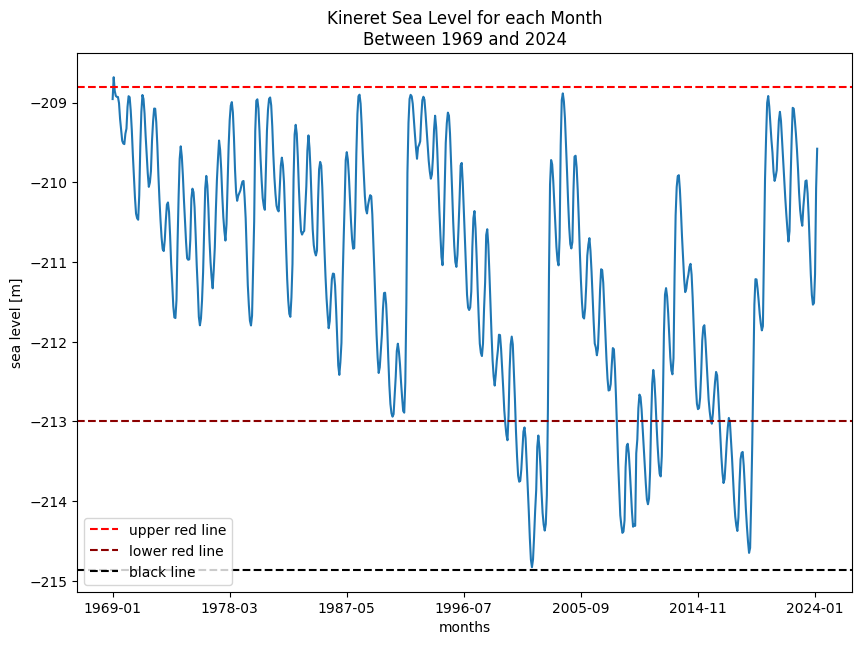

In [9]:
x_vals = [str(period) for period in dataset.index]
y_vals = dataset.values

plt.figure(figsize=(10, 7))
plt.plot(x_vals, y_vals)
plt.title("Kineret Sea Level for each Month\nBetween 1969 and 2024")
plt.xlabel("months")
plt.ylabel("sea level [m]")
plt.xticks([0, 110, 220, 330, 440, 550, 660])

red_upper_line = -208.8
red_lower_line = -213
black_line = -214.87

plt.axhline(red_upper_line, linestyle="--", color="r", label="upper red line")
plt.axhline(red_lower_line, linestyle="--", color="darkred", label="lower red line")
plt.axhline(black_line, linestyle="--", color="black", label="black line")

plt.legend();

Let us find some interesting insights from the plot above (and discuss them):

In [10]:
print(f"Max sea level: {dataset.max()[0]}, received at {dataset.idxmax()[0]}")

Max sea level: -208.682, received at 1969-02


In [11]:
print(f"Max sea level: {dataset.min()[0]}, received at {dataset.idxmin()[0]}")

Max sea level: -214.829, received at 2001-11


In [12]:
cnt = 0
for _, r in dataset.iterrows():
  if r["Level"] < -213:
    cnt += 1

print(f"{round(100*(cnt/len(dataset)), 2)}% of all recorded months, had an average sea level above the Lower Red Line.")

14.78% of all recorded months, had an average sea level above the Lower Red Line.


From the graph above, we can conclude the following:

-	The maximum sea level (since recording began) is -208.682, and was received on 1969-02.

-	The minimum sea level (since recording began) is -214.829, and was received on 2001-11.

-	The duration of the Kineret sea level being under the “lower red line” is about 14.78% of the total duration recorded.

-	Fortunately, the Kineret sea level the “black line” only once (2001-11).


Now, let us break down our data into its key features: trend, seasonality and noise:

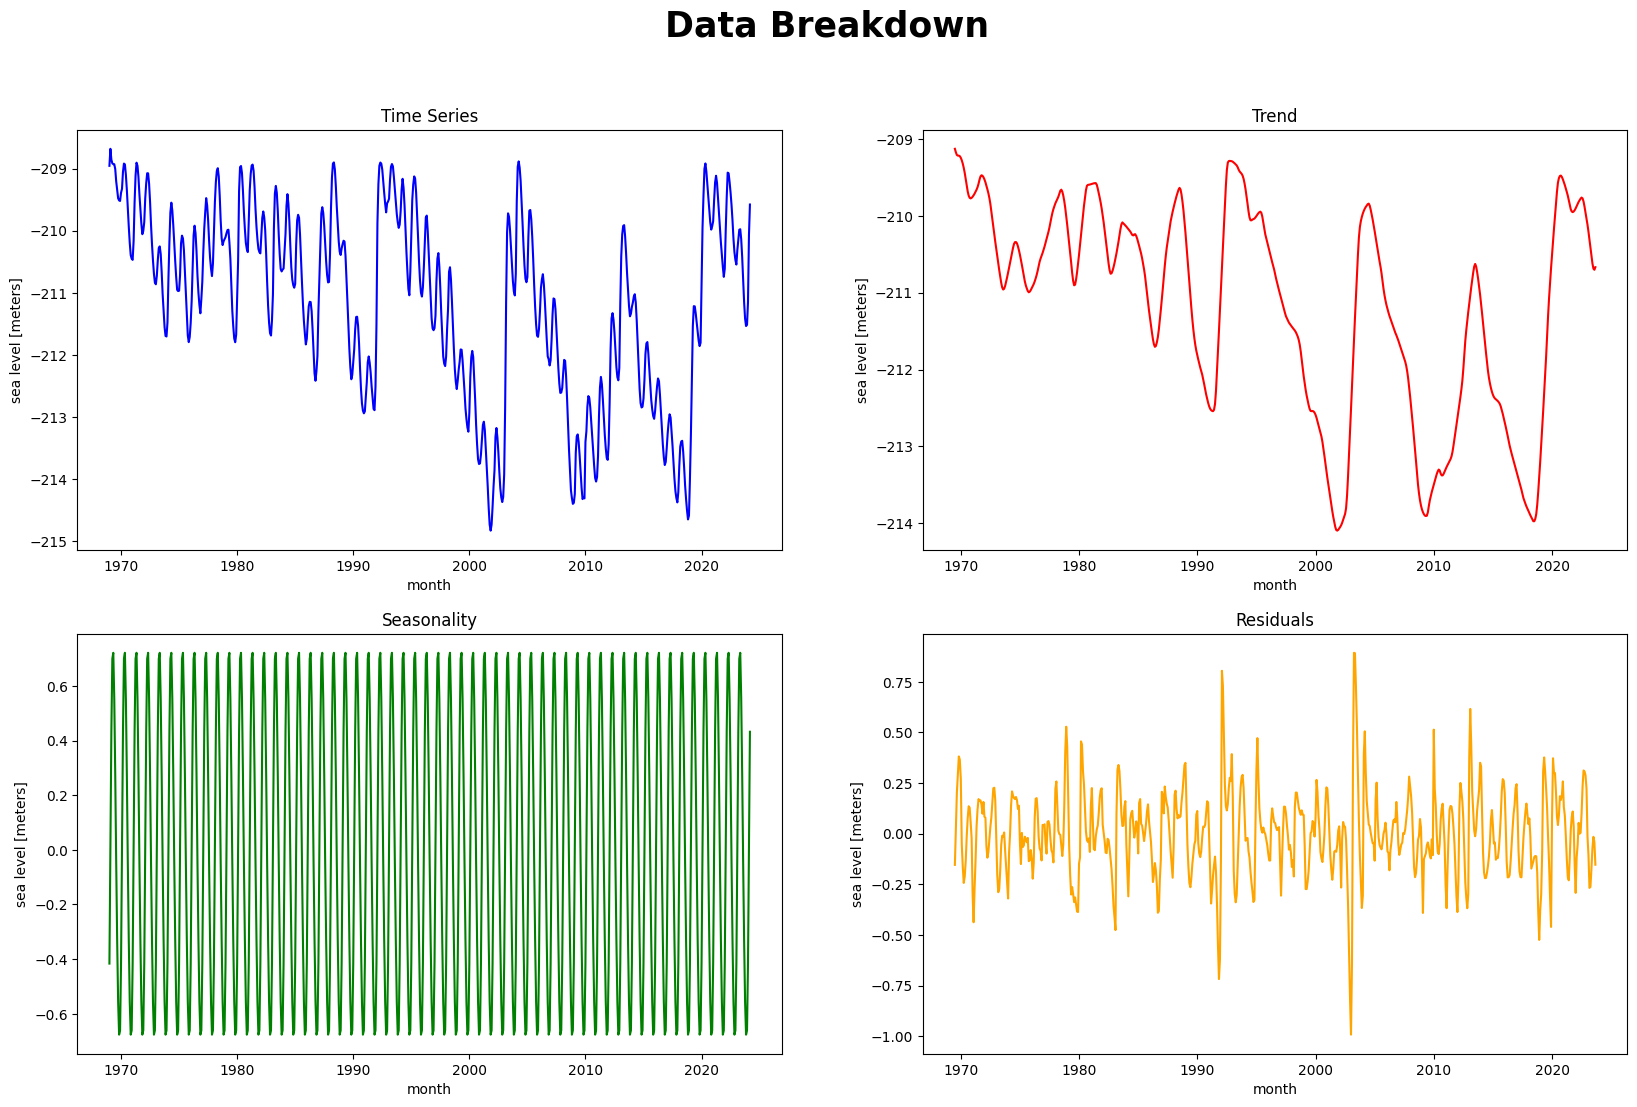

In [13]:
decomp = seasonal_decompose(dataset, period=12)

fig, axs = plt.subplots(2, 2, figsize=(20, 12))
plt.suptitle("Data Breakdown", fontsize=25, fontweight="bold")

xticks = [i*120 + 12 for i in range(6)]
xticklabels = [1970 + i*10 for i in range(6)]

# time series data
axs[0, 0].plot(dataset.to_numpy(), color="blue")
axs[0, 0].set_xlabel("month")
axs[0, 0].set_ylabel("sea level [meters]")
axs[0, 0].set_xticks(xticks)
axs[0, 0].set_xticklabels(xticklabels)
axs[0, 0].set_title("Time Series")

# trend
axs[0, 1].plot(decomp.trend.to_numpy(), color="red")
axs[0, 1].set_xlabel("month")
axs[0, 1].set_ylabel("sea level [meters]")
axs[0, 1].set_xticks(xticks)
axs[0, 1].set_xticklabels(xticklabels)
axs[0, 1].set_title("Trend")

# seasonality
axs[1, 0].plot(decomp.seasonal.to_numpy(), color="green")
axs[1, 0].set_xlabel("month")
axs[1, 0].set_ylabel("sea level [meters]")
axs[1, 0].set_xticks(xticks)
axs[1, 0].set_xticklabels(xticklabels)
axs[1, 0].set_title("Seasonality")

# residuals
axs[1, 1].plot(decomp.resid.to_numpy(), color="orange")
axs[1, 1].set_xlabel("month")
axs[1, 1].set_ylabel("sea level [meters]")
axs[1, 1].set_xticks(xticks)
axs[1, 1].set_xticklabels(xticklabels)
axs[1, 1].set_title("Residuals");

From the plots above, we can conclude the following:

- The trend seems not to be constant. That is, the Kineret sea level seems to be regularly changing, in both directions.

- The seasonality plot appears to be highly periodic. Thus, it greatly indicates that our time series data has a significant seasonality component. This insight does not surprise us, since the Kineret sea level is largely affected by the weather (specifically, precipitations), which is seasonal.

- The residuals seem to be symmetrically distributed around the line $y=0$. This highly indicates that the residuals’ mean is 0.


Now, let us "zoom in" into short and interesing intervals:

In [14]:
def display_interval(interval_start, interval_end):
  records = dataset.loc[interval_start:interval_end]

  records.plot(legend=False)
  plt.title(f"""Kineret Level for each Month in Interval
  {interval_start.replace("-", " (") + ")"} - {interval_end.replace("-", " (") + ")"}""")
  plt.xlabel("months")
  plt.ylabel("sea level [meters]")

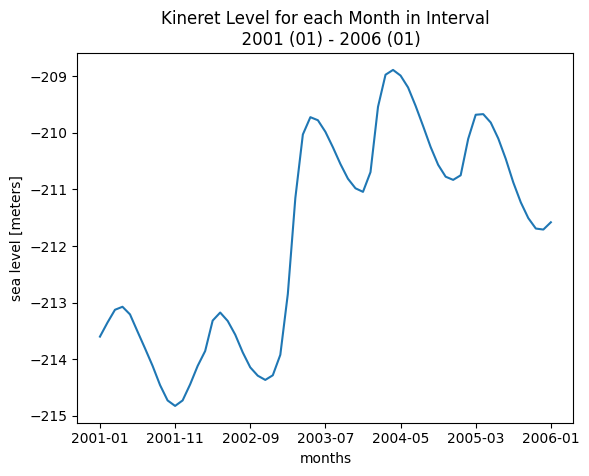

In [15]:
display_interval('2001-01', '2006-01')

In this graph, we can see a significant increase in the Kineret sea level, in a very short time period – roughly 5 meters in about 6 months!.

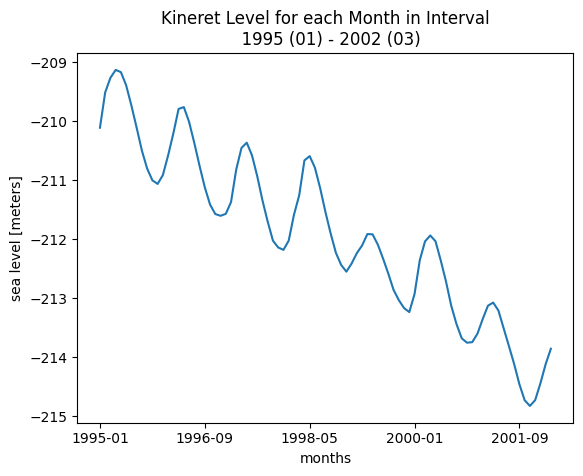

In [16]:
display_interval('1995-01', '2002-03')

In the right graph, we can see a steady decrease in the Kineret sea level, roughly 6 meters in about 6 years – an average of 1 meter per year!.

Lastly, let us intuitively visualize the time series' seasonality:

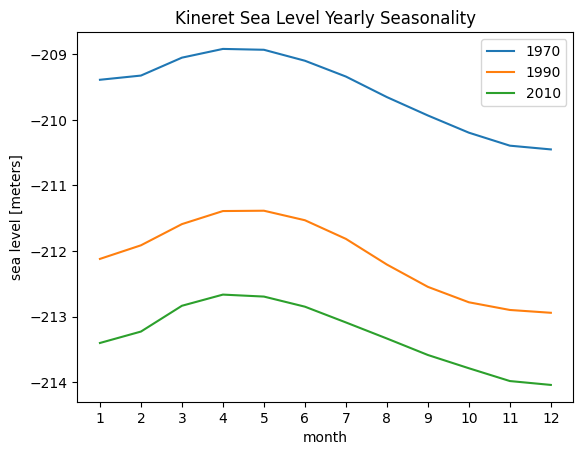

In [17]:
records_1970 = dataset.loc["1970-01":"1970-12"]
records_1990 = dataset.loc["1990-01":"1990-12"]
records_2010 = dataset.loc["2010-01":"2010-12"]

plt.plot(range(1, 13), records_1970["Level"], label="1970")
plt.plot(range(1, 13), records_1990["Level"], label="1990")
plt.plot(range(1, 13), records_2010["Level"], label="2010")

plt.title("Kineret Sea Level Yearly Seasonality")
plt.xlabel("month")
plt.ylabel("sea level [meters]")

plt.xticks(range(1, 13))

plt.legend()
plt.show()

As we can see, although the years are greatly far apart, the sea level pattern throughout each one appears to be nearly identical. In addition, there appears to be significant difference of the Kineret level between 1970 and 2010.

## **Part 2**

After exploring our time series, in this part, we will fit different models to our time series, to see which one fits best.

We will choose to experiment with the following models:

- SARIMA

- Exponential Smoothing

- Prophet

For each model, we will performe tests on a wide range of values for their parameters, in order to find the optimal ones. We will evaluate the different parameter values using the following measures:

- BIC score
- MSE – we split the data into train and test sets, where the train set consists of the first 85% of the records, and the test set consists of the last 15% of the records . Then, we trained our models on the train set, created a forecast for the test set, and calculated the MSE between the forecasted values and the true values.

These measures will guide us to choose the best parameters for each of the three models.


### **SARIMA Model**

As we saw Part 1, the Kineret sea level is largely affected by the seasons. Hence, it is not stationary.

Let us try to transform it into one, by performing differentiation of 12 time periods (to try and remove the yearly seasonality):

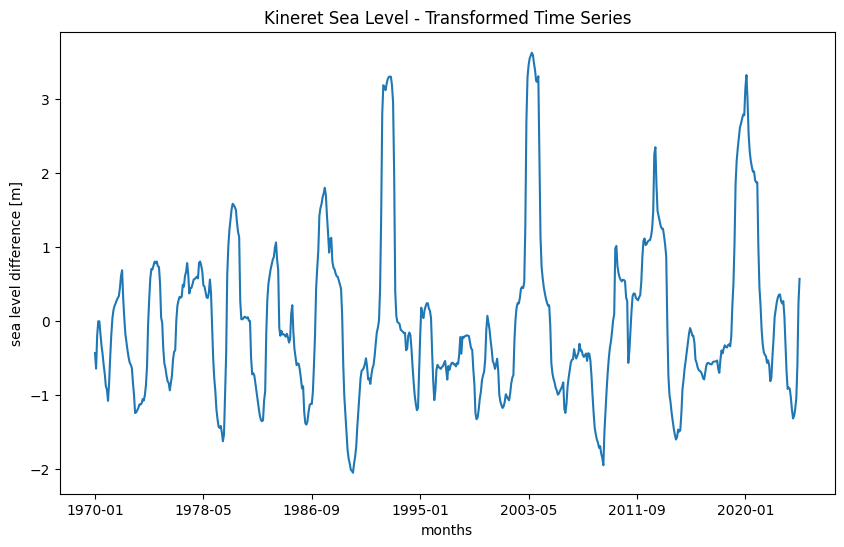

In [18]:
dataset_diff = dataset.diff(periods=12)
dataset_diff = dataset_diff.dropna()

dataset_diff.plot(figsize=(10, 6), legend=False)
plt.title("Kineret Sea Level - Transformed Time Series")
plt.xlabel("months")
plt.ylabel("sea level difference [m]");

As we can see, the seasonality is much less present than in the original time series. In addition, the transformed time series apprears to be quite stationary.

In order to further verify this assumption, let us performe the ADF test (for stationarity):

In [19]:
adftest = adfuller(dataset_diff['Level'], autolag='AIC', regression='ct')
print("------------ADF Test Results------------")

print("\nNull Hypothesis: The series has a unit root (non-stationary)\n")

print("ADF-Statistic:", round(adftest[0], 3))
print("P-Value:", round(adftest[1], 6))


------------ADF Test Results------------

Null Hypothesis: The series has a unit root (non-stationary)

ADF-Statistic: -5.565
P-Value: 1.7e-05


As we can see, we recived $PV < 10^{-4}$.

Thus, we can conclude that the transformed time series is stationary with high statistical significance .

Hence, we can display the ACFs and PACFs of the transformed time series (as they are well defined):

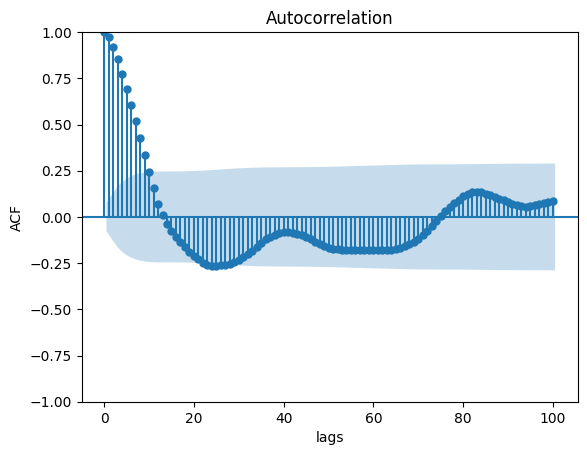

In [20]:
tsaplots.plot_acf(dataset_diff, lags=100)
plt.xlabel("lags")
plt.ylabel("ACF");

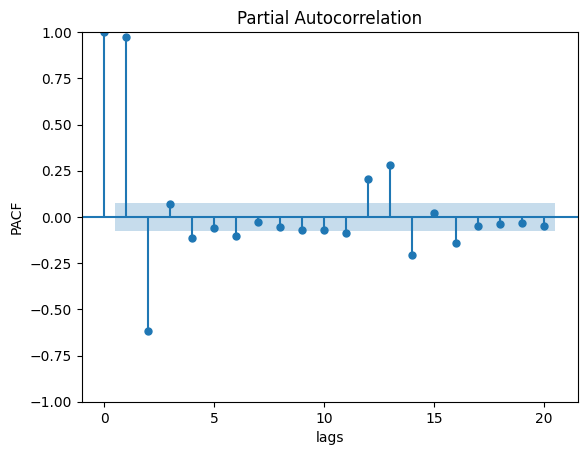

In [21]:
tsaplots.plot_pacf(dataset_diff, lags=20)
plt.xlabel("lags")
plt.ylabel("PACF");

From the graphs above, we can observe the following:

- The ACFs decay to zero.

- The first and second PACFs are clearly not zeroes. In addition, PACFs 12, 13 and 14 are also not zeroes.

- It is reasonable to assume that the rest of the PACFs are zeroes.

Hence, we can conclude that models which are probably suitable for the transformed time series are $AR(1)$ and $AR(2)$.

Therefore, models that might fit the original time series are:

- Model 1 - $SARIMA(1, 0, 0)(0, 1, 0)_{12}$.

- Model 2 - $SARIMA(2, 0, 0)(0, 1, 0)_{12}$.

In addition, models that take into account higher non-zero PACFs are:

- Model 3 - $SARIMA(1, 0, 0)(1, 1, 0)_{12}$.

- Model 4 - $SARIMA(2, 0, 0)(1, 1, 0)_{12}$.

#### **Model 1**

In [22]:
model_1 = SARIMAX(dataset, order=(1, 0, 0), seasonal_order=(0, 1, 0, 12))
model_1 = model_1.fit()

print(model_1.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Level   No. Observations:                  663
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 12)   Log Likelihood                  -6.029
Date:                            Thu, 09 May 2024   AIC                             16.058
Time:                                    14:27:58   BIC                             25.015
Sample:                                01-01-1969   HQIC                            19.532
                                     - 03-01-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9756      0.007    138.904      0.000       0.962       0.989
sigma2         0.0594      0.001   

In [23]:
def get_MSE_model_SARIMA(df, order, seasonal_order):
  n = len(df)
  slice_idx = int(n * 0.85)

  # take 85% of the data as the trainset
  train_df = df[:slice_idx]

  # take 15% of the data as the testset
  test_df = df[slice_idx:]

  model = SARIMAX(train_df, order=order, seasonal_order=seasonal_order)
  model = model.fit()

  pred_num = n - slice_idx
  forcast = model.get_forecast(steps=pred_num)
  preds = forcast.predicted_mean
  residuals = np.array(test_df["Level"]) - np.array(preds)

  MSE = (residuals**2).mean()

  return round(MSE, 3)

In [24]:
MSE_model_1 = get_MSE_model_SARIMA(dataset, order=(1, 0, 0), seasonal_order=(0, 1, 0, 12))
print(f"The MSE for Model 1 on the Test Set is: {MSE_model_1}")

The MSE for Model 1 on the Test Set is: 4.542


Let us summarize the results below:

- The BIC Score for this model is 25.015.

- The MSE for this model on the test set is 4.542.

Now, in order to visually assess the model’s performance on the test set, let us create a residual plot:

In [25]:
def plot_residuals(model, filter_func=None, model_name=""):
  residuals = pd.DataFrame(model.resid.iloc[12:], columns=['residuals'])

  if filter_func is not None:
    residuals = residuals[residuals['residuals'].apply(filter_func)]

  residuals['idx'] = residuals.index
  residuals.plot.scatter(x='idx', y="residuals");
  plt.axhline(y = 0, color = 'r', linestyle = '-')
  plt.title(f"{model_name} Residuals Plot")
  plt.xlabel("months")
  plt.xticks([0, 120, 240, 360, 480, 600])
  plt.show()

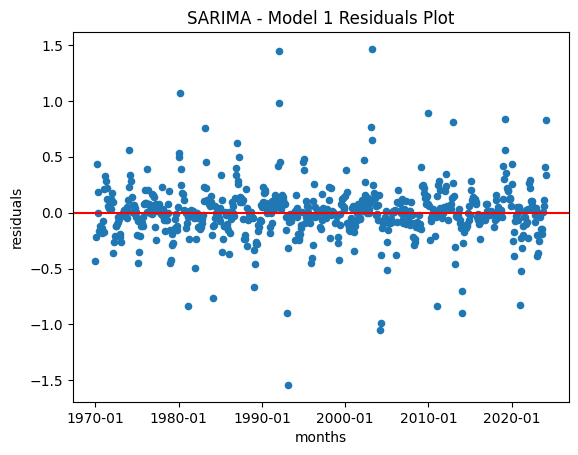

In [26]:
plot_residuals(model_1, model_name="SARIMA - Model 1")

As we can see, there are 3 points which their absolute value is greater than 1.3. These points comprise less than 0.5% of the data, hence they are clearly outliers. Therefore, according to the "minimal ink-paper ratio" principle, we will remove them (when plotting the graph).

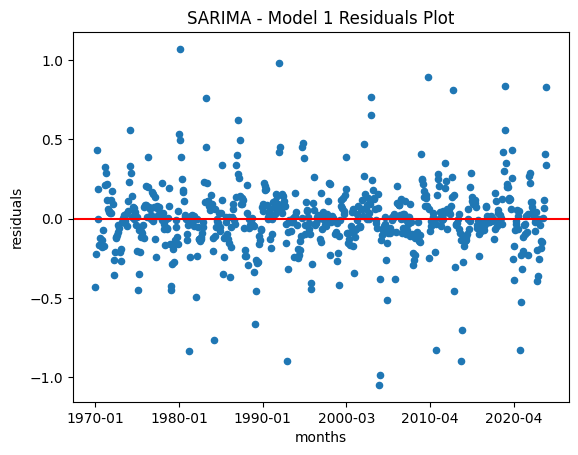

In [27]:
filter_func = lambda x: abs(x) < 1.3
plot_residuals(model_1, filter_func, model_name="SARIMA - Model 1")

The residual plot seems to be valid:

- The points seems to be symmetrical around the line $y=0$. This insight indicates that the expected error is 0.

- It appears that the points are uniformally distributed around the line. This insight indicates that the variance is constant.

#### **Model 2**

In [28]:
model_2 = SARIMAX(dataset, order=(2, 0, 0), seasonal_order=(0, 1, 0, 12))
model_2 = model_2.fit()

print(model_2.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Level   No. Observations:                  663
Model:             SARIMAX(2, 0, 0)x(0, 1, 0, 12)   Log Likelihood                 158.072
Date:                            Thu, 09 May 2024   AIC                           -310.145
Time:                                    14:28:03   BIC                           -296.709
Sample:                                01-01-1969   HQIC                          -304.934
                                     - 03-01-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5893      0.016     98.802      0.000       1.558       1.621
ar.L2         -0.6296      0.016   

In [29]:
MSE_model_2 = get_MSE_model_SARIMA(dataset, order=(2, 0, 0), seasonal_order=(0, 1, 0, 12))
print(f"The MSE for Model 2 on the Test Set is: {MSE_model_2}")

The MSE for Model 2 on the Test Set is: 3.986


Let us summarize the results below:

- The BIC Score for this model is -296.709.

- The MSE for this model on the test set is 3.986.

Now, in order to visually assess the model’s performance on the test set, let us create a residual plot:

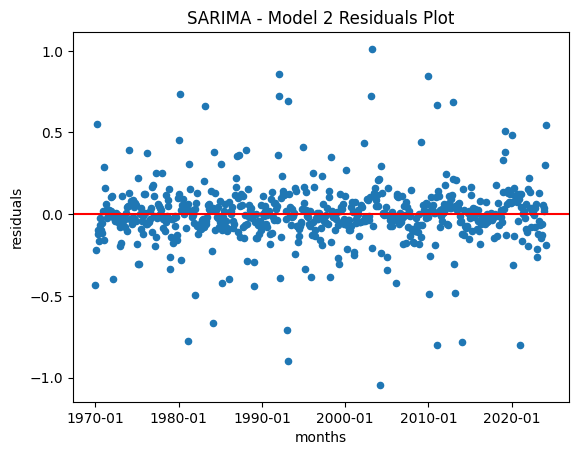

In [30]:
plot_residuals(model_2, model_name="SARIMA - Model 2")

The residual plot seems to be valid:

- The points seems to be symmetrical around the line $y=0$. This insight indicates that the expected error is 0.

- It appears that the points are uniformally distributed around the line. This insight indicates that the variance is constant.

#### **Model 3**

In [31]:
model_3 = SARIMAX(dataset, order=(1, 0, 0), seasonal_order=(1, 1, 0, 12))
model_3 = model_3.fit()

print(model_3.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Level   No. Observations:                  663
Model:             SARIMAX(1, 0, 0)x(1, 1, 0, 12)   Log Likelihood                  57.516
Date:                            Thu, 09 May 2024   AIC                           -109.032
Time:                                    14:28:06   BIC                            -95.597
Sample:                                01-01-1969   HQIC                          -103.821
                                     - 03-01-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9830      0.007    136.514      0.000       0.969       0.997
ar.S.L12      -0.4268      0.023   

Let us summarize the results below:

- The BIC Score for this model is -95.597.

- The average error for this model on the test set is 9.017.

Now, in order to visually assess the model’s performance on the test set, let us create a residual plot:

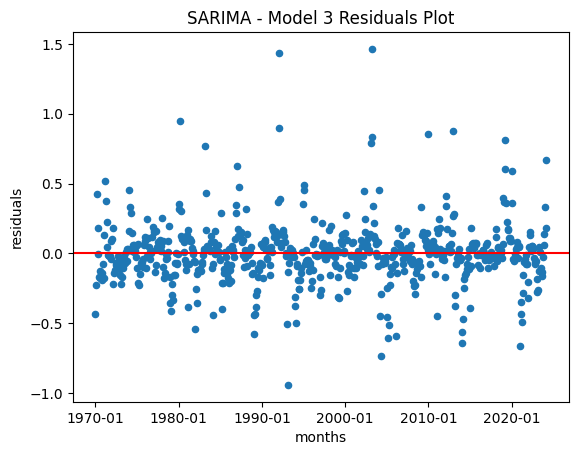

In [32]:
plot_residuals(model_3, model_name="SARIMA - Model 3")

As we can see, there are 3 points which their absolute value is greater than 0.9. These points comprise less than 0.5% of the data, hence they are clearly outliers. Therefore, according to the "minimal ink-paper ratio" principle, we will remove them (when plotting the graph).

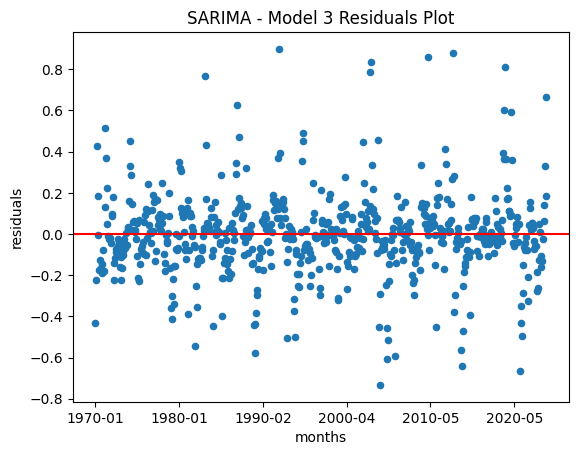

In [33]:
filter_func = lambda x: abs(x) < 0.9
plot_residuals(model_3, filter_func, model_name="SARIMA - Model 3")

In [34]:
MSE_model_3 = get_MSE_model_SARIMA(dataset, order=(1, 0, 0), seasonal_order=(1, 1, 0, 12))
print(f"The MSE for Model 3 on the Test Set is: {MSE_model_3}")

The MSE for Model 3 on the Test Set is: 9.017


The residual plot seems to be valid:

- The points seems to be symmetrical around the line $y=0$. This insight indicates that the expected error is 0.

- It appears that the points are uniformally distributed around the line. This insight indicates that the variance is constant.

#### **Model 4**

In [35]:
model_4 = SARIMAX(dataset, order=(2, 0, 0), seasonal_order=(1, 1, 0, 12))
model_4 = model_4.fit()

print(model_4.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Level   No. Observations:                  663
Model:             SARIMAX(2, 0, 0)x(1, 1, 0, 12)   Log Likelihood                 225.327
Date:                            Thu, 09 May 2024   AIC                           -442.654
Time:                                    14:28:13   BIC                           -424.740
Sample:                                01-01-1969   HQIC                          -435.706
                                     - 03-01-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6078      0.017     95.397      0.000       1.575       1.641
ar.L2         -0.6340      0.017   

Let us summarize the results below:

- The BIC Score for this model is -424.740.

- The MSE for this model on the test set is 4.434.

Now, in order to visually assess the model’s performance on the test set, let us create a residual plot:

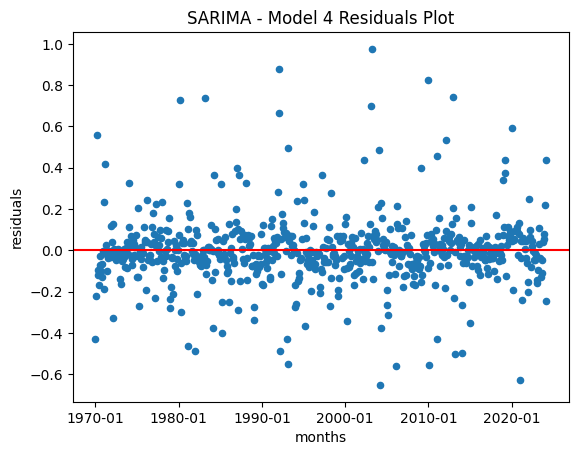

In [36]:
plot_residuals(model_4, model_name="SARIMA - Model 4")

In [37]:
MSE_model_4 = get_MSE_model_SARIMA(dataset, order=(2, 0, 0), seasonal_order=(1, 1, 0, 12))
print(f"The MSE for Model 4 on the Test Set is: {MSE_model_4}")

The MSE for Model 4 on the Test Set is: 4.434


The residual plot seems to be valid:

- The points seems to be symmetrical around the line $y=0$. This insight indicates that the expected error is 0.

- It appears that the points are uniformally distributed around the line. This insight indicates that the variance is constant.

#### **Best SARIMA Model**

Now, after evaluating all four SARIMA models, let us discuss the results and choose the best one.

First, As mentioned, in all four models, the residuals are distributed as we would like to expect. However, for models 2 and 4, both the BIC score and the MSE are the best among the models.

For model 2, the MSE is better than model 4's. For model 4, the BIC score is better than model 2's.

Thus, since we prefer to choose our models based on practical measures, we will decide to put more emphasis on the MSE measure, and choose model 2 as the SARIMA model we will proceed with.

After choosing our best SARIMA model, let us visually demonstrate the model's performance, by plotting its forecasts on the test set alongside the real values.

In [38]:
def plot_forecasts_SARIMA(df, order, seasonal_order):
  n = len(df)
  slice_idx = int(n * 0.85)

  # take 85% of the data as the trainset
  train_df = df[:slice_idx]

  # take 15% of the data as the testset
  test_df = df[slice_idx:]

  model = SARIMAX(train_df, order=order, seasonal_order=seasonal_order)
  model = model.fit()

  pred_num = n - slice_idx
  forecasts = model.forecast(steps=pred_num)

  # plot observations
  plt.figure(figsize=(10, 7))
  plt.plot(df.index, df, label='observations')

  # plot predicted values
  plt.plot(test_df.index, forecasts, color='r', label='forecasts')

  plt.title("Test Set Forecasts VS Real Values - SARIMA Model")
  plt.xlabel("months")
  plt.ylabel("sea level [m]")
  plt.xticks([0, 120, 240, 360, 480, 600])
  plt.legend()
  plt.show()


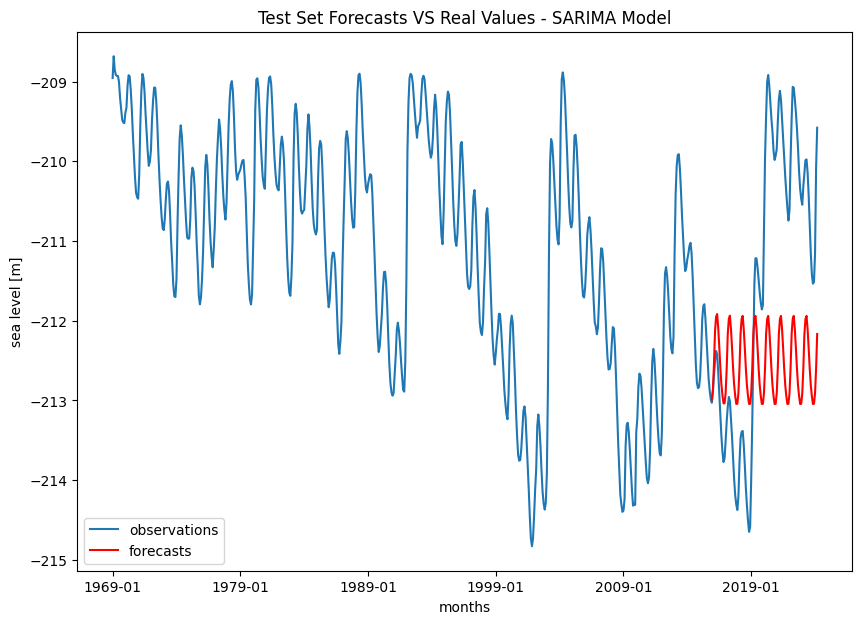

In [39]:
plot_forecasts_SARIMA(dataset, order=(2, 0, 0), seasonal_order=(0, 1, 0, 12))

We will discuss the results in this plot later on.

### **Exponential Smoothing Models**

#### **Simple Exponential Smoothing Model**

In this section, we would like to create a Simple Exponential Smoothing model for our time series. Let us be reminded that this model requires a hyperparameter $\alpha$ (smoothing level).

Since there is a single parameter, which exists in the interval of [0, 1], we will use the grid search method in order to find an optimal $\alpha$ value.

In [40]:
def get_MSE_model_SES(df, alpha):
  n = len(df)
  slice_idx = int(n * 0.85)

  # take 85% of the data as the trainset
  train_df = df[:slice_idx]

  # take 15% of the data as the testset
  test_df = df[slice_idx:]

  model = SimpleExpSmoothing(train_df)
  model = model.fit(smoothing_level=alpha, optimized=False)

  pred_num = n - slice_idx
  forcast = model.forecast(steps=pred_num)
  preds = forcast.mean()
  residuals = np.array(test_df["Level"]) - np.array(preds)

  MSE = (residuals**2).mean()

  return round(MSE, 3)


def get_measure_lists(alpha_lst):
  BIC_lst = []
  MSE_lst = []

  for alpha in alpha_lst:
    cur_model = SimpleExpSmoothing(dataset, initialization_method="estimated").fit(smoothing_level=alpha, optimized=False)

    cur_BIC = cur_model.bic
    BIC_lst.append(cur_BIC)

    cur_MSE = get_MSE_model_SES(dataset, alpha=alpha)
    MSE_lst.append(cur_MSE)

  return BIC_lst, MSE_lst

First, let us use an initial search in order to find the potential interval of the optimal $\alpha$ value.

We will plot a total of 20 points across the entire domain of $\alpha$.

In [41]:
alpha_lst = np.linspace(0, 1, 20)
BIC_lst, MSE_lst = get_measure_lists(alpha_lst)

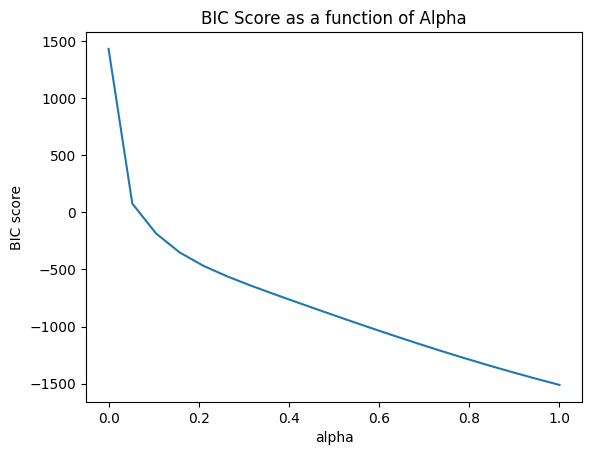

In [42]:
plt.plot(alpha_lst, BIC_lst)
plt.title("BIC Score as a function of Alpha")
plt.xlabel("alpha")
plt.ylabel("BIC score");

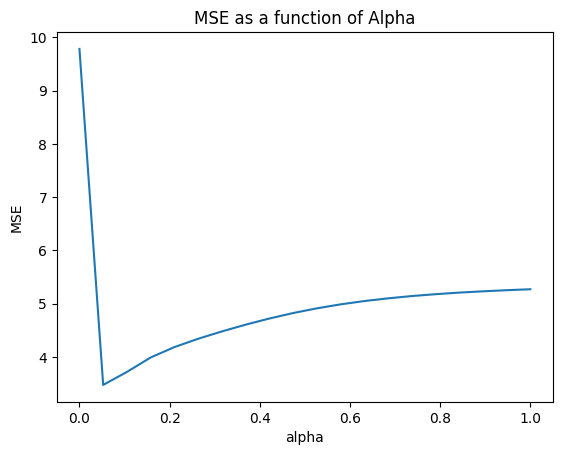

In [43]:
plt.plot(alpha_lst, MSE_lst)
plt.title("MSE as a function of Alpha")
plt.xlabel("alpha")
plt.ylabel("MSE");

As we can see, the best BIC score is received at $\alpha=1.0$. However, the best MSE is received for some $\alpha$ in the interval [0, 0.2]. Since we are interested in practical measures, we will put more emphasis on the MSE measure.

Let us "zoom in" in order to examine said interval:

In [44]:
alpha_lst_zoomed_in = np.linspace(0.0, 0.2, 50)
_, MSE_lst_zoomed_in = get_measure_lists(alpha_lst_zoomed_in)

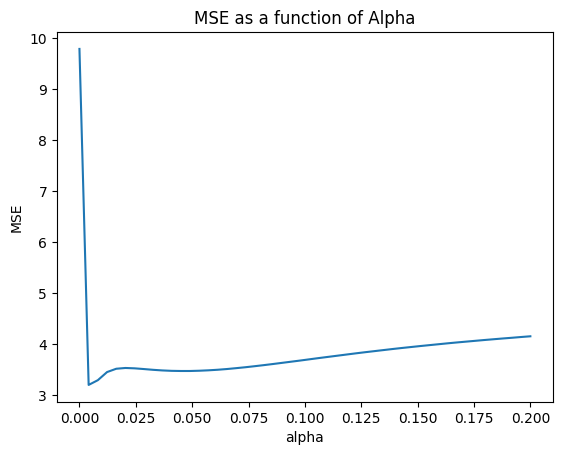

In [45]:
plt.plot(alpha_lst_zoomed_in, MSE_lst_zoomed_in)
plt.title("MSE as a function of Alpha")
plt.xlabel("alpha")
plt.ylabel("MSE");

Let us find the $\alpha$ value that minimizes the MSE:

In [46]:
tup_lst = [(alpha, MSE) for alpha, MSE in zip(alpha_lst_zoomed_in, MSE_lst_zoomed_in)]

alpha_min, MSE_min = sorted(tup_lst, key=lambda x: x[1])[0]

print(f"The minimum MSE is received for alpha: {round(alpha_min, 3)}")
print(f"Minimum MSE: {MSE_min}")

The minimum MSE is received for alpha: 0.004
Minimum MSE: 3.199


Therefore, the $\alpha$ we will choose for our Simple Exponential Smoothing model is $\alpha=0.004$.

Let us find the BIC score for this $\alpha$ value below:

In [47]:
# find BIC for said alpha
best_SES_model = SimpleExpSmoothing(dataset, initialization_method="estimated").fit(smoothing_level=alpha_min, optimized=False)
print(f"The BIC score received for said alpha: {round(best_SES_model.bic, 3)}")

The BIC score received for said alpha: 693.652


Lastly, we will display the residual plot for the best SES model below:

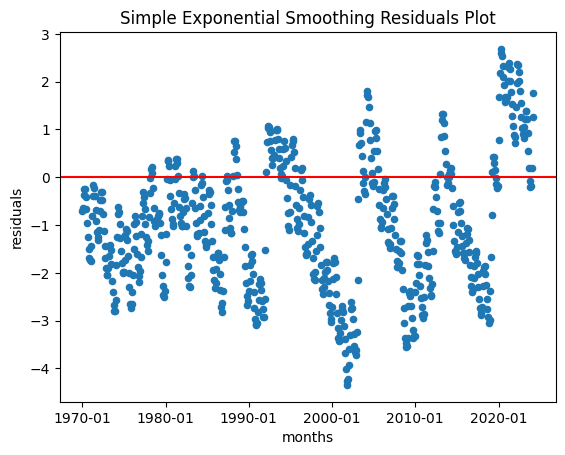

In [48]:
plot_residuals(best_SES_model, model_name="Simple Exponential Smoothing")

As we can see, the residual plot is clearly not valid:

- The points are not symmetrical around the line $y=0$, which indicates that the expected error is not 0. This insight demonstrates that there is a factor which affects the time series data, but our model does not capture.

- The points do not appear to be uniformly distributed around the line $y=0$. This indicates that the variance is not constant.

To further explore the performance of this model, let us display the model's forecasts on the test set (alongside the true values):

In [49]:
def plot_forecasts_SES(df,alpha):
  n = len(df)
  slice_idx = int(n * 0.85)

  # take 85% of the data as the trainset
  train_df = df[:slice_idx]

  # take 15% of the data as the testset
  test_df = df[slice_idx:]

  model = SimpleExpSmoothing(train_df, initialization_method="estimated")

  model = model.fit(smoothing_level=alpha)

  pred_num = n - slice_idx
  forecasts = model.forecast(steps=pred_num)

  # plot observations
  plt.figure(figsize=(13, 6))
  plt.plot(df.index, df, label='observations')

  # plot predicted values
  plt.plot(test_df.index, forecasts, color='green', label='forecasts')

  plt.title("Test Set Forecasts VS Real Values - Exponential Smoothing Model")
  plt.xlabel("months")
  plt.ylabel("sea level [m]")
  plt.xticks([0, 120, 240, 360, 480, 600])
  plt.legend()
  plt.show()

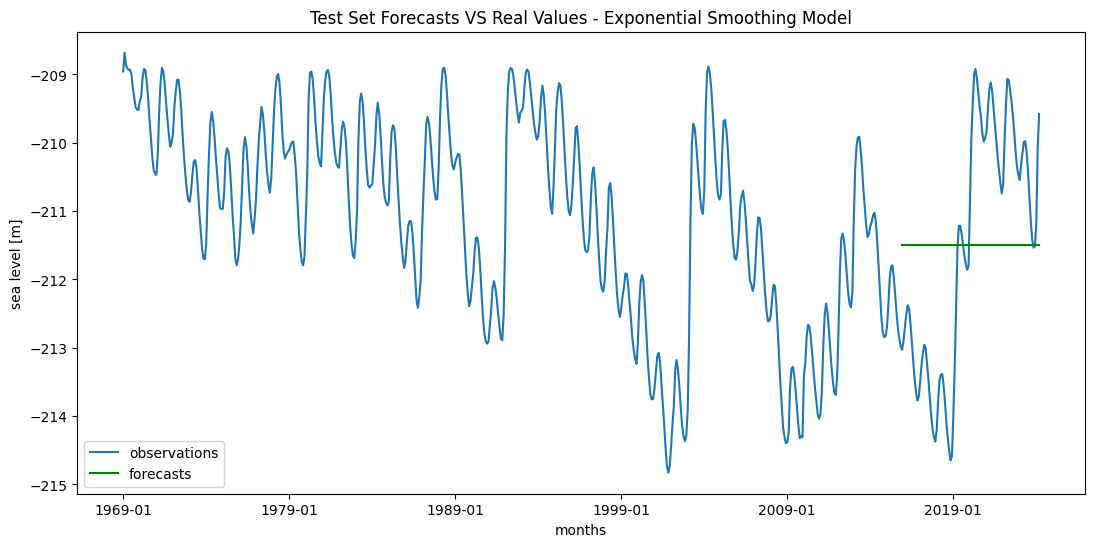

In [50]:
plot_forecasts_SES(dataset, alpha=0.004)

As we can see, the forecasted values form a simple, horizontal line. This indicates that our model is too simple for this time series. Hence, in the next section, we will utilize a more advanced Exponential Smoothing model.

*At first, the horizontal forecasts line seems odd. As a result, we checked the plot of the model's forecasts for different $\alpha$ values. Yet, all $\alpha$ values resulted in horizontal forecast lines as well.

#### **Holt-Winters Model**

In this section, we will use the Holt-Winters model for our time series.

This model has three main hyperparameters:

- $\alpha$ (smoothing level)

- $\beta$ (smoothing trend)

- $\gamma$ (smoothing seasonal)

Ideally, we would like to perform the grid search method in order to fine-tune said hyperparameters. However, since there are three different ones, it is computationally heavy to accurately find the optimum.

As a result, we will use the built-in function of the model in order to find the hyperparameter values that we will proceed with.

In addition, as seen in the SARIMA model section, there is a yearly seasonality in our time series. Thus, we will choose the ```seasonal_periods=12``` when defining the model.

Finally, we will define the ```trend``` and ```seasonal``` components of the model to be "additive", since it better aligns with the nature of our time series.

In [51]:
model_ES = ExponentialSmoothing(
    dataset,
    seasonal_periods=12,
    trend="add",
    seasonal="add",
    initialization_method="estimated",
)

model_ES = model_ES.fit(optimized=True)

print(model_ES.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Level   No. Observations:                  663
Model:             ExponentialSmoothing   SSE                             14.917
Optimized:                         True   AIC                          -2483.610
Trend:                         Additive   BIC                          -2411.662
Seasonal:                      Additive   AICC                         -2482.548
Seasonal Periods:                    12   Date:                 Thu, 09 May 2024
Box-Cox:                          False   Time:                         14:28:23
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               1.0000000                alpha                 True
smoothing_trend          

As we can see, the chosen hyperparameters are:

- $\alpha=1.0$

- $\beta=0.708$

- $\gamma=0.0$

In [52]:
def get_MSE_model_ES(df, L, R, S):
  n = len(df)
  slice_idx = int(n * 0.85)

  # take 85% of the data as the trainset
  train_df = df[:slice_idx]

  # take 15% of the data as the testset
  test_df = df[slice_idx:]

  model = ExponentialSmoothing(
    train_df,
    seasonal_periods=12,
    trend="add",
    seasonal="add",
    initialization_method="estimated"
    )
  model = model.fit(smoothing_level=L, smoothing_trend=R, smoothing_seasonal=S, optimized=False)

  pred_num = n - slice_idx
  forcast = model.forecast(steps=pred_num)
  preds = forcast.mean()
  residuals = np.array(test_df["Level"]) - np.array(preds)

  MSE = (residuals**2).mean()

  return round(MSE, 3)

In [53]:
MSE_model_ES = get_MSE_model_ES(dataset, L=1.0, R=0.708, S=0.0)
print(f"The MSE for the ES Model on the Test Set is: {MSE_model_ES}")

The MSE for the ES Model on the Test Set is: 3.16


Let us summarize the results below:

- The BIC Score for this model is -2411.662.

- The MSE for this model on the test set is 3.16.

Now, in order to visually assess the model’s performance on the test set, let us create a residual plot:

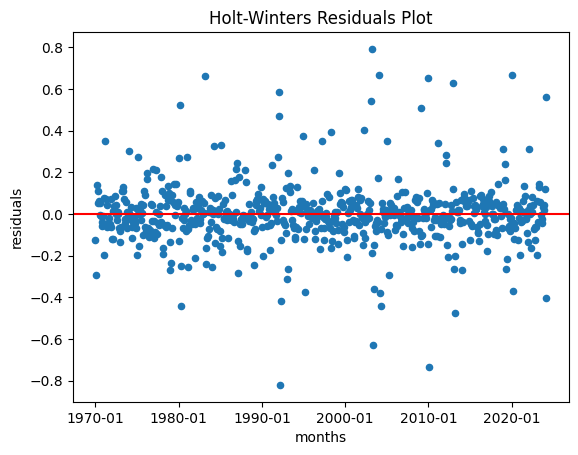

In [54]:
plot_residuals(model_ES, model_name="Holt-Winters")

As we can see, there are 9 points which their absolute value is greater than 0.6. These points comprise less than 1.5% of the data, hence they are clearly outliers. Therefore, according to the "minimal ink-paper ratio" principle, we will remove them (when plotting the graph).

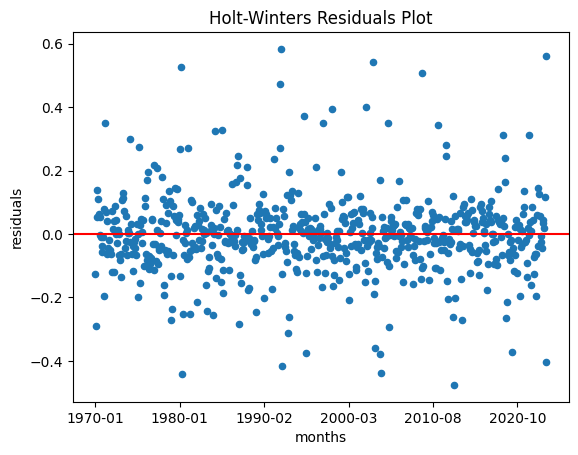

In [55]:
filter_func = lambda x: abs(x) < 0.6
plot_residuals(model_ES, filter_func, model_name="Holt-Winters")

as oppose to SES model, the residual plot of this model seems to be valid:

- The points seems to be symmetrical around the line $y=0$. This insight indicates that the expected error is 0.

- It appears that the points are uniformally distributed around the line. This insight indicates that the variance is constant.

Now, let us visually demonstrate the model's performance, by plotting its forecasts on the test set alongside the real values:

In [56]:
def plot_forecasts_ES(df, L, R, S):
  n = len(df)
  slice_idx = int(n * 0.85)

  # take 85% of the data as the trainset
  train_df = df[:slice_idx]

  # take 15% of the data as the testset
  test_df = df[slice_idx:]

  model = ExponentialSmoothing(
    train_df,
    seasonal_periods=12,
    trend="add",
    seasonal="add",
    initialization_method="estimated"
    )

  model = model.fit(smoothing_level=L, smoothing_trend=R, smoothing_seasonal=S, optimized=False)

  pred_num = n - slice_idx
  forecasts = model.forecast(steps=pred_num)

  # plot observations
  plt.figure(figsize=(10, 7))
  plt.plot(df.index, df, label='observations')

  # plot predicted values
  plt.plot(test_df.index, forecasts, color='green', label='forecasts')

  plt.title("Test Set Forecasts VS Real Values - Exponential Smoothing Model")
  plt.xlabel("months")
  plt.ylabel("sea level [m]")
  plt.xticks([0, 120, 240, 360, 480, 600])
  plt.legend()
  plt.show()

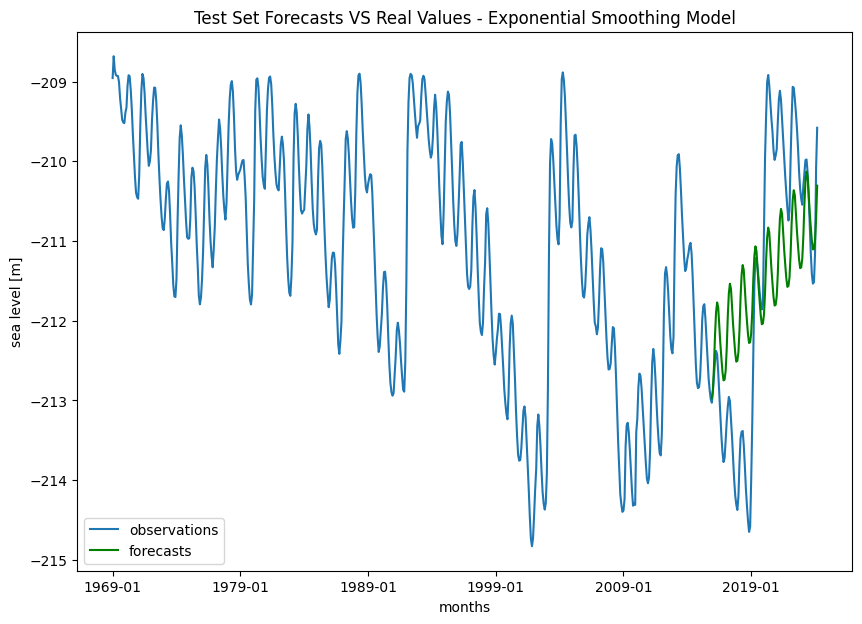

In [57]:
  plot_forecasts_ES(dataset, L=1.0, R=0.708, S=0.0)

We will discuss the results in this plot later on.

### **The Prophet Model**

In this section, we will create the Prophet model for our time series.

As we know, the Prophet model is extremely customizable, with a high number of hyperparameters to choose from. However, in order to have a reasonable number of tests, we will focus on fine-tuning only the ```changepoint_prior_scale``` and ```seasonality_prior_scale``` parameters. These parameters control the flexibility of the trend and seasonality, respectively. In other words, they determine how drastically the trend and seasonality change at any given point. A higher value of these parameters allows for more flexibility, meaning that the model can adapt more quickly to changes in the data. Since our time series changes quite drastically, we hope that these hyperparameter will help us capture it.

The domain of the ```changepoint_prior_scale``` parameter is the interval [0.001, 0.5]. Theoretically, the parameter's value can be set to be greater than 0.5, however upon reading online it appears extremely not recommended to do so. Its default value is 0.05. As a result of the mentioned flexibility in our time series, we would like to examine different values for this parameter between the default value and the recommended upper bound (the interval [0.05, 0.5]).

Upon reading online, the default value of the ```seasonality_prior_scale``` parameter is 10, and values that are considered "large" are about 100. Thus, we would like to examine different values for this parameter between the default value and the suggested large value (the interval [10, 100]).

In addition, when defining the model, we will set ```seasonality_mode='additive'``` and ```growth='linear'``` due to the nature of our data. Moreover, we will choose not to incorporate holidays into our model, since they are short-term, and we assume that they do not have any noticeable effect on the Kineret sea level during their time period.

*Note that the the BIC scroe is not available for this model.

In [58]:
def create_prophet_df(df):
  prophet_df = df.copy()
  prophet_df["ds"] = pd.to_datetime(prophet_df.index)
  prophet_df.columns = ["y", "ds"]
  prophet_df = prophet_df[["ds", "y"]]
  return prophet_df


def get_MSE_model_Prophet(df, model):
  n = len(df)
  slice_idx = int(n * 0.85)
  pred_num = n - slice_idx

  # take 85% of the data as the trainset
  train_df = df[:slice_idx]

  # take 15% of the data as the testset
  test_df = df[slice_idx:]

  future_dates = model.make_future_dataframe(periods=pred_num, freq="MS")
  forecast = model.predict(future_dates)

  residuals = np.array(test_df["y"]) - np.array(forecast["yhat"].tail(pred_num))

  MSE = (residuals**2).mean()

  return round(MSE, 3)

In [59]:
prophet_dataset = create_prophet_df(dataset)

In [ ]:
changepoint_prior_lst = np.linspace(0.05, 0.5, 30)
seasonality_prior_lst = np.linspace(10, 100, 30)
MSE_lst = []

for cpp in changepoint_prior_lst:
  for sp in seasonality_prior_lst:
    model_prophet = Prophet(changepoint_prior_scale=cpp, seasonality_prior_scale=sp,
                            seasonality_mode='additive', growth='linear')

    model_prophet.fit(prophet_dataset)

    MSE = get_MSE_model_Prophet(prophet_dataset, model_prophet)
    MSE_lst.append((cpp, sp, MSE))

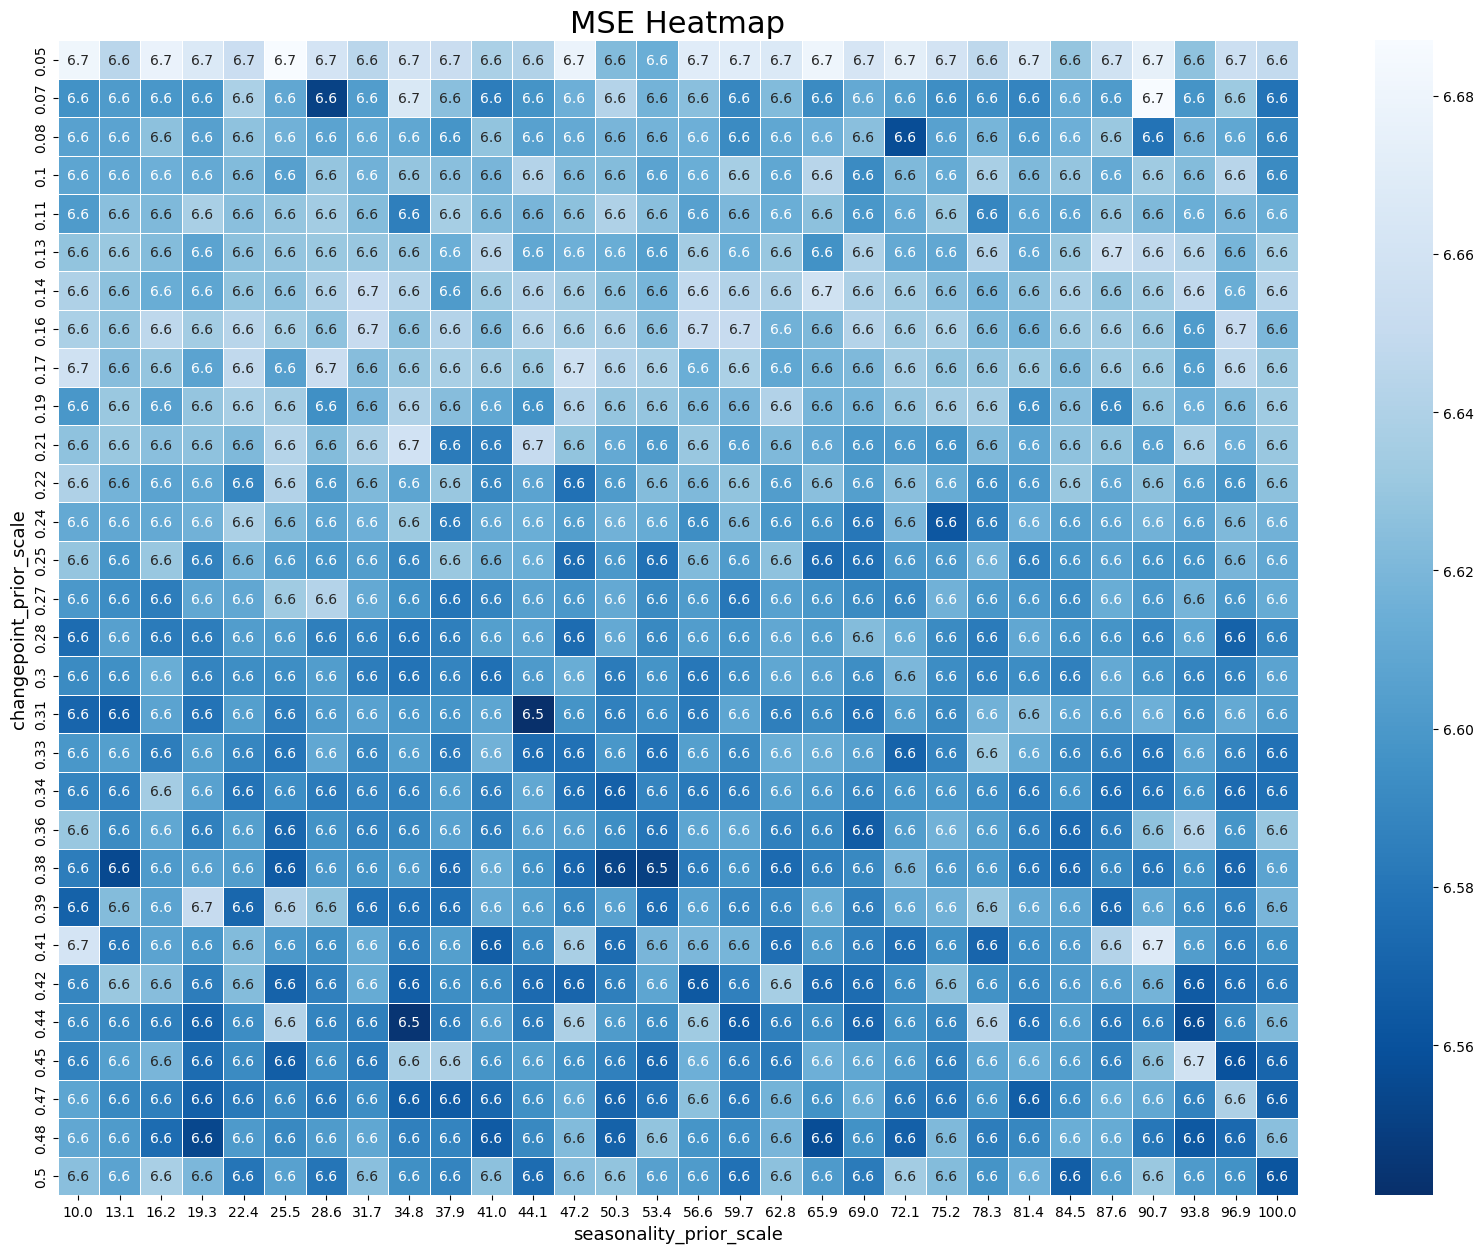

In [61]:
trend_val2num = {val: num for num, val in enumerate(np.linspace(0.05, 0.5, 30))}
seasonality_val2num = {val: num for num, val in enumerate(np.linspace(10, 100, 30))}

arr = np.zeros((30, 30))

for cpp, sp, MSE in MSE_lst:
  i = trend_val2num[cpp]
  j = seasonality_val2num[sp]

  arr[i, j] = MSE

plt.figure(figsize=(20, 15))
sns.heatmap(arr, cmap="Blues_r", annot=True, linewidth=0.5)
plt.title("MSE Heatmap", fontsize=22)
plt.xlabel("seasonality_prior_scale", fontsize=13)
plt.ylabel("changepoint_prior_scale", fontsize=13)
plt.xticks(list(np.arange(30)+0.5), labels=np.round(np.linspace(10, 100, 30), 1))
plt.yticks(list(np.arange(30)+0.5), labels=np.round(np.linspace(0.05, 0.5, 30), 2));

As we can see, the best values for the pair of hyperparameters are:

```changepoint_prior_scale=0.31``` and ```seasonality_prior_scale=44.1```.

Let us initialize and train a Prophet model with the hyperparameters found:

In [ ]:
best_prophet_model = Prophet(changepoint_prior_scale=0.31, seasonality_prior_scale=44.1,
                            seasonality_mode='additive', growth='linear')
best_prophet_model = best_prophet_model.fit(prophet_dataset);

In [63]:
# print the parameter values of the model
for param, vals in best_prophet_model.params.items():
  print(f"parameter name: {param}")
  print("values:")
  print(vals[0])
  print("----------------------------")

parameter name: lp__
values:
[3433.43]
----------------------------
parameter name: k
values:
[-0.0843608]
----------------------------
parameter name: m
values:
[-0.972573]
----------------------------
parameter name: delta
values:
[ 1.25636e-02 -1.63465e-02  4.49281e-02  2.18758e-01 -2.88081e-01
  2.45535e-01 -2.63205e-01  1.79116e-01 -2.59077e-01  5.62997e-01
 -8.21911e-01  6.51757e-01  1.36209e-01 -4.87455e-01  4.46563e-02
 -1.81838e-02 -3.78288e-02  6.19599e-02  8.18508e-01 -9.66361e-01
  9.46961e-02 -7.21984e-02  3.95872e-01 -1.02168e-01  6.59893e-04]
----------------------------
parameter name: sigma_obs
values:
[0.00330615]
----------------------------
parameter name: beta
values:
[ 3.24856e-03 -1.15526e-03 -9.73344e-04  5.24301e-04 -6.38198e-04
  1.64100e-03  3.08954e-04  1.51640e-03  1.11940e-03  1.07074e-03
  1.63507e-03  4.87677e-05  1.26645e-03 -1.07052e-03  4.58894e-04
 -1.68350e-03 -6.35382e-04 -1.93184e-03 -1.38318e-03 -1.05114e-03]
----------------------------
paramete

In [64]:
MSE_model_prophet = get_MSE_model_Prophet(prophet_dataset, best_prophet_model)
print(f"The MSE for the Prophet Model on the Test Set is: {MSE_model_prophet}")

The MSE for the Prophet Model on the Test Set is: 6.595


Now, in order to visually assess the model’s performance on the test set, let us create a residual plot:

In [65]:
def plot_residuals_prophet(prophet_df, model):
  forecast = model.predict()

  merged = pd.merge(prophet_df, forecast, on='ds')
  residuals = merged['yhat'] - merged['y']

  merged["residuals"] = residuals
  merged = merged[["ds", "residuals"]]

  plt.scatter(merged["ds"], merged["residuals"])
  plt.axhline(y = 0, color = 'r', linestyle = '-')
  plt.title("Prophet Residuals Plot")
  plt.xlabel("months")
  plt.ylabel("residuals")
  plt.show()

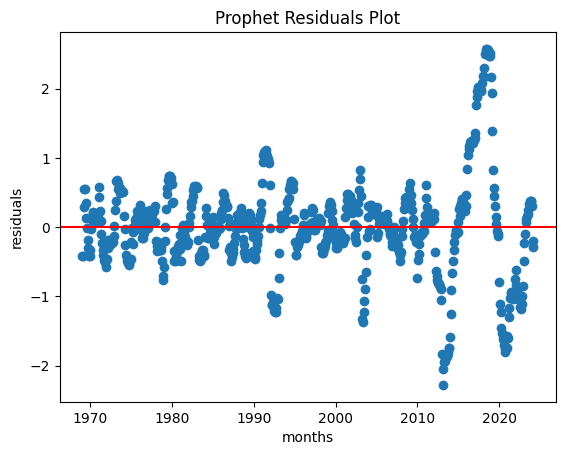

In [66]:
plot_residuals_prophet(prophet_dataset, best_prophet_model)

As we can see, the residual plot is quite valid:

The points are symmetrical around the line $y=0$, which indicates that the expected error is 0.
However, the points do not appear to be uniformly distributed around the line $y=0$, which indicates that the variance is not constant.

Now, let us visually demonstrate the model's performance, by plotting its forecasts on the test set alongside the real values:

In [67]:
def plot_forecasts_Prophet(df):
  n = len(df)
  slice_idx = int(n * 0.85)
  pred_num = n - slice_idx

  # take 85% of the data as the trainset
  train_df = df[:slice_idx]

  # take 15% of the data as the testset
  test_df = df[slice_idx:]

  model = Prophet(changepoint_prior_scale=0.31, seasonality_prior_scale=44.1,
                              seasonality_mode='additive', growth='linear')
  model = model.fit(prophet_dataset)

  prophet_df = create_prophet_df(df)

  future_dates = model.make_future_dataframe(periods=pred_num, freq="MS")
  forecasts = model.predict(future_dates)
  forecast_values = np.array(forecasts["yhat"].tail(pred_num))

  # plot observations
  plt.figure(figsize=(10, 7))
  plt.plot(df.index, df, label='observations')

  # plot predicted values
  plt.plot(test_df.index, forecast_values, color='orange', label='forecasts')

  plt.title("Test Set Forecasts VS Real Values - Prophet Model")
  plt.xlabel("months")
  plt.ylabel("sea level [m]")
  plt.xticks([0, 120, 240, 360, 480, 600])
  plt.legend()
  plt.show()

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpe2opjte6/7utomaax.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpe2opjte6/p0ltn54m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34926', 'data', 'file=/tmp/tmpe2opjte6/7utomaax.json', 'init=/tmp/tmpe2opjte6/p0ltn54m.json', 'output', 'file=/tmp/tmpe2opjte6/prophet_modelwb_sxzj2/prophet_model-20240509144112.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:41:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:41:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


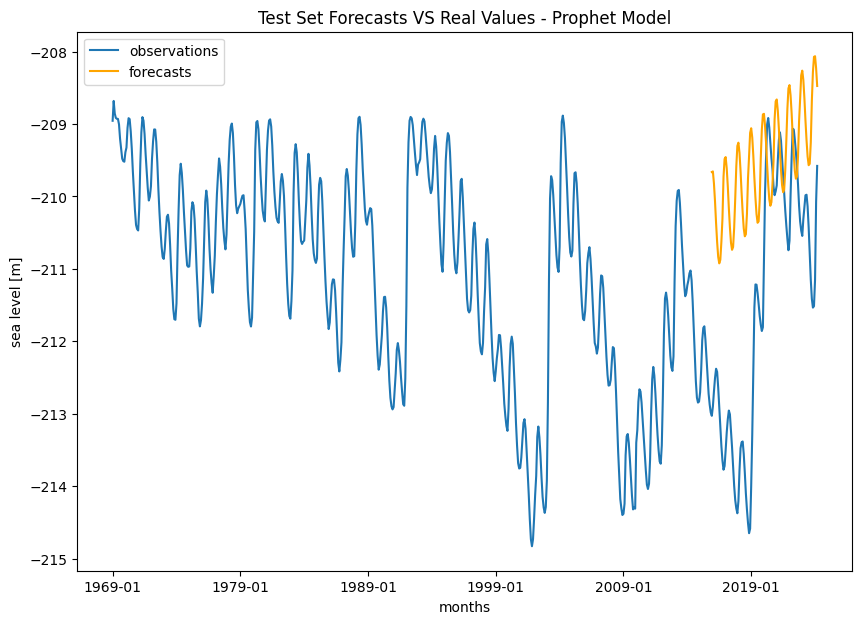

In [68]:
plot_forecasts_Prophet(dataset)

We will discuss the results in this plot later on.

### **Final Model Selection**

In the sections above, we evaluated different models on our time series data. Let us be reminded of the models we proceeded with, and their results:

- $SARIMA(2, 0, 0)(0, 1, 0)_{12}$
  - BIC = -296.709
  - MSE = 3.986

- Exponential Smoothing (Holt-Winters)
  - BIC = -2411.709
  - MSE = 3.16

- Prophet
  - MSE = 6.595

As we can see, the Exponential Smoothing model has both the best MSE and BIC score. In addition, the MSE of the Prophet model is quite larger than the others.

Now, we will display all of the models' forecasts on the test set in the same plot (along with the true values):

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpe2opjte6/dzuk_3sx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpe2opjte6/vvlf5wqg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62200', 'data', 'file=/tmp/tmpe2opjte6/dzuk_3sx.json', 'init=/tmp/tmpe2opjte6/vvlf5wqg.json', 'output', 'file=/tmp/tmpe2opjte6/prophet_model3mtli6cv/prophet_model-20240509144114.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:41:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:41:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


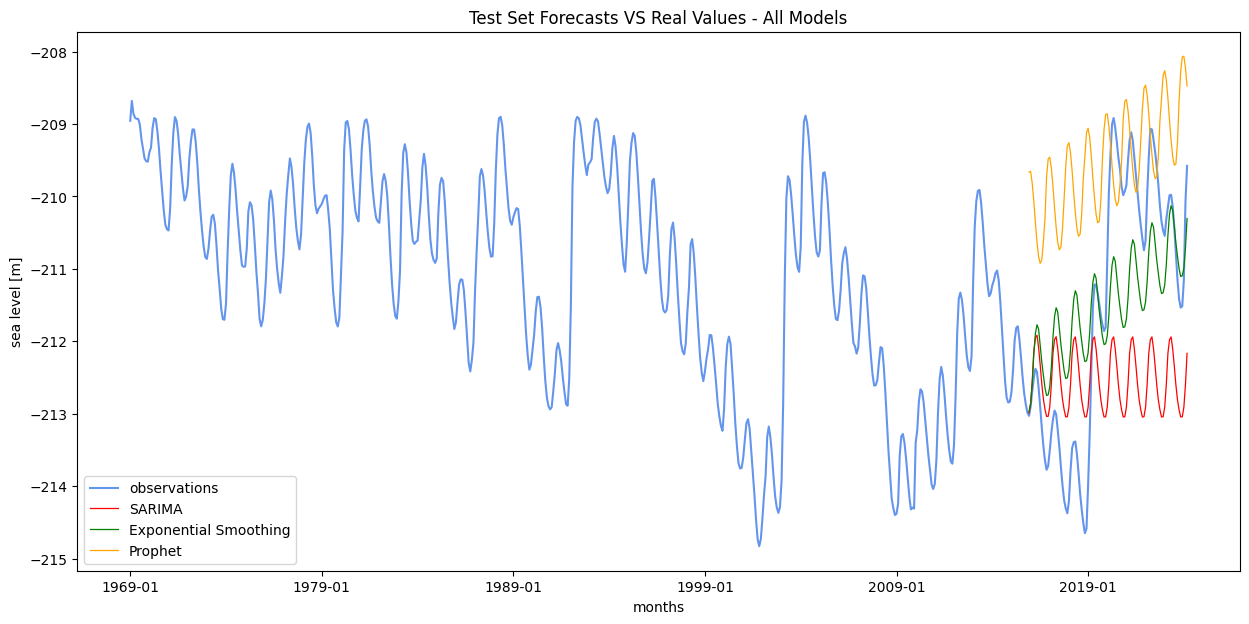

In [69]:
n = len(dataset)
slice_idx = int(n * 0.85)
pred_num = n - slice_idx

# take 85% of the data as the trainset
train_df = dataset[:slice_idx]

# take 15% of the data as the testset
test_df = dataset[slice_idx:]

# plot observations
plt.figure(figsize=(15, 7))
plt.plot(dataset.index, dataset, color="cornflowerblue", label='observations')

# plot SARIMA forecasts
model = SARIMAX(train_df, order=(2, 0, 0), seasonal_order=(0, 1, 0, 12))
model = model.fit()

forecasts = model.forecast(steps=pred_num)
plt.plot(test_df.index, forecasts, color='r', linewidth=0.9, label='SARIMA')

# plot Exponential Smoothing forecasts
model = ExponentialSmoothing(
  train_df,
  seasonal_periods=12,
  trend="add",
  seasonal="add",
  initialization_method="estimated"
  )

model = model.fit(smoothing_level=1.0, smoothing_trend=0.708, smoothing_seasonal=0.0, optimized=False)

forecasts = model.forecast(steps=pred_num)
plt.plot(test_df.index, forecasts, color='green', linewidth=0.9, label='Exponential Smoothing')

# plot Prophet forecasts
prophet_df = create_prophet_df(dataset)
model = Prophet(changepoint_prior_scale=0.31, seasonality_prior_scale=44.1,
                            seasonality_mode='additive', growth='linear')
model = model.fit(prophet_df)

future_dates = model.make_future_dataframe(periods=pred_num, freq="MS")
forecasts = model.predict(future_dates)
forecast_values = np.array(forecasts["yhat"].tail(pred_num))

plt.plot(test_df.index, forecast_values, color='orange', linewidth=0.9, label='Prophet')

plt.title("Test Set Forecasts VS Real Values - All Models")
plt.xlabel("months")
plt.ylabel("sea level [m]")
plt.xticks([0, 120, 240, 360, 480, 600])
plt.legend()
plt.show()

Let us discuss and compare the performances of the different models:

First, we can see that all three models capture the yearly seasonality of the Kineret sea level very well.

However, the Prophet model (yellow) does not seem to capture the true values at all. We can see that the first forecast highly overestimates the true value, a phenomenon which continues in most of its predictions.
Regarding the SARIMA model (red), its first predictions are quite accurate. However, it remains monotone and does not reflect any trend in the time series.

Lastly, the Exponential Smoothing model (green) seems to perform quite decently. That is, the first and last few forecast points seem to capture the true values very well. This result is quite impressive, especially on the last forecast points (which are over 8 years ahead). In addition, although the model did not capture the extreme highs and lows in the Kineret sea level during this period, it indeed captured the overall trend.
As a result, in our eyes, the Exponential Smoothing model appears visually superior in the plot above.


Now, let us display future forecasts 24 months ahead:

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpe2opjte6/q8gy4q9p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpe2opjte6/p8kzhx46.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96011', 'data', 'file=/tmp/tmpe2opjte6/q8gy4q9p.json', 'init=/tmp/tmpe2opjte6/p8kzhx46.json', 'output', 'file=/tmp/tmpe2opjte6/prophet_modelge3_4cex/prophet_model-20240509144117.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:41:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:41:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


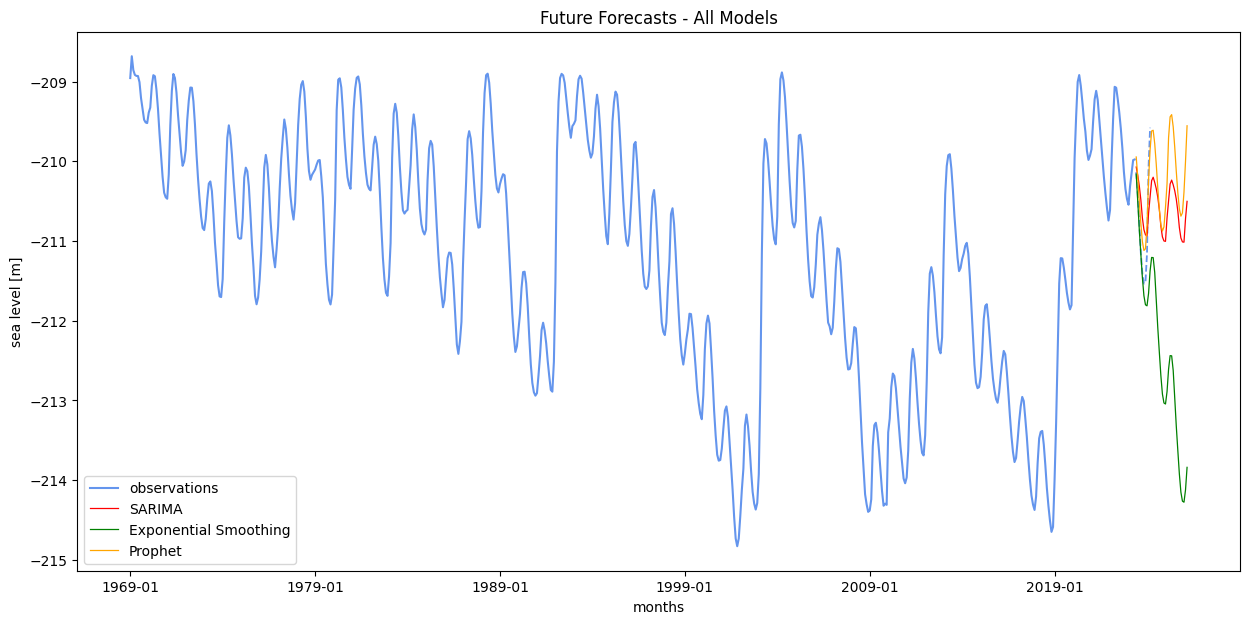

In [70]:
IDX = 653

# plot observations
plt.figure(figsize=(15, 7))
plt.plot(dataset.index[:IDX], dataset[:IDX], color="cornflowerblue", label='observations')
plt.plot(dataset.index[IDX:], dataset[IDX:], color="cornflowerblue", linestyle="--", linewidth=1.3)

# create periods for forecasts
period_range = pd.period_range(start="2023-06", end="2026-03", freq="M")
period_strs = [str(period) for period in period_range]
STEPS = 34

# plot SARIMA forecasts
model = SARIMAX(dataset[:IDX], order=(2, 0, 0), seasonal_order=(0, 1, 0, 12))
model = model.fit()

forecasts = model.forecast(steps=STEPS)
plt.plot(period_strs, forecasts, color='r', linewidth=0.9, label='SARIMA')

# plot Exponential Smoothing forecasts
model = ExponentialSmoothing(
                        dataset[:IDX],
                        seasonal_periods=12,
                        trend="add",
                        seasonal="add",
                        initialization_method="estimated")
model = model.fit(smoothing_level=1.0, smoothing_trend=0.708, smoothing_seasonal=0.0, optimized=False)

forecasts = model.forecast(steps=STEPS)

plt.plot(period_strs, forecasts, color='green', linewidth=0.9, label='Exponential Smoothing')

# plot Prophet forecasts
prophet_df = create_prophet_df(dataset[:IDX])
model = Prophet(changepoint_prior_scale=0.31, seasonality_prior_scale=44.1,
                            seasonality_mode='additive', growth='linear')
model = model.fit(prophet_df)

future_dates = model.make_future_dataframe(periods=STEPS, freq="MS")
forecasts = model.predict(future_dates)
forecast_values = np.array(forecasts["yhat"].tail(STEPS))

plt.plot(period_strs, forecast_values, color='orange', linewidth=0.9, label='Prophet')

plt.title("Future Forecasts - All Models")
plt.xlabel("months")
plt.ylabel("sea level [m]")
plt.xticks([0, 120, 240, 360, 480, 600])
plt.legend()
plt.show()

As we can see, all models provided decent forecasts. It appears that both the SARIMA and the Prophet models made relatively conservative forecasts, whereas the Exponential Smoothing model made bolder ones. However, we can see that those forecasts seemingly fit the time series in a natural manner.

*Note that we start forecasting 10 months before the last recorded time period. That is because there is a large spike towards the last records in our data, which misleads our models and negatively affects their predictions.

From the above discussion, we conclude that in our eyes, the model which overall suits our time series best, is the **Exponential Smoothing (Holt-Winters) model**.

## **Part 3**

In this part, we will introduce two explanatory variables for our time series: natural and man-made.

We chose this approach to better understand the factors that are associated with our time series.

### **Natural Explanatory Variable: Weather Conditions**

For this variable, we chose to model it as a combination of the following attributes:

- Maximum Temperature (Monthly Average)
- Minimum Temperature (Monthly Average)
- Accumulated Rainfall (Monthly)

The data mentioned above was collected from the website of the Israel Meteorological Service. For the most accurate results, we extracted all records available (for the selected weather station): January 2008 until March 2024

The data was collected in two datasets:

- temp_2008_2024

- rainfall_2008_2024


#### **Preprocessing**

##### **Temperature**

The 'temp_2008_2024' dataset contains daily records regarding the daily maximum and minimum temperature records. Therefore, in order to receive monthly temperature data (the same time periods as our original time series), for each month we will need to average acorss all its daily records.

Let us load and preprocess the 'temp_2008_2024' dataset (please upload the [temp_2008_2024.csv](https://drive.google.com/file/d/112wIdktpxzdfzYBzqznABWjFnUZfhZH1/view?usp=sharing) file to this notebook from the project's drive)::


In [98]:
def cast_month(month):
  if len(month) == 1:
    return "0" + month

  return month

In [99]:
temp_2008_2024 = pd.read_csv("temp_2008_2024.csv")

temp_2008_2024["Month"] = temp_2008_2024["Date"].apply(lambda date: cast_month(date.split("/")[1]))
temp_2008_2024["Year"] = temp_2008_2024["Date"].apply(lambda date: date.split("/")[2])

temp_2008_2024 = temp_2008_2024.drop("Date", axis=1)

In [100]:
avg_month_temp = temp_2008_2024.groupby(["Year", "Month"]).mean()

In [101]:
period_range = pd.period_range(start="2008-01", end="2024-03", freq="M")
avg_month_temp.set_index(period_range, inplace=True)
avg_month_temp = avg_month_temp.apply(lambda x: round(x, 3))

In [102]:
avg_month_temp

,Max Temp,Min Temp
2008-01,16.003,7.690
2008-02,19.248,9.383
2008-03,26.148,13.706
2008-04,30.603,16.363
2008-05,31.948,17.806
...,...,...
2023-11,27.910,18.113
2023-12,23.435,14.765
2024-01,19.084,12.126
2024-02,20.169,10.855


Let us manually fill in missing values, as mentioned in the report:

In [103]:
avg_month_temp.loc["2018-08", "Max Temp"] = 37.98
avg_month_temp.loc["2018-08", "Min Temp"] = 25.012

Now, Let us display the temperature time series:

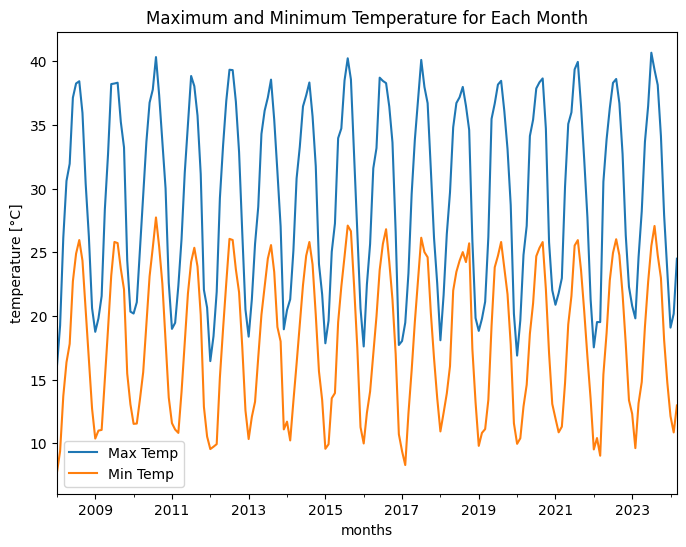

In [104]:
avg_month_temp[["Max Temp", "Min Temp"]].plot(figsize=(8, 6))
plt.title("Maximum and Minimum Temperature for Each Month")
plt.xlabel("months")
plt.ylabel("temperature [°C]");

##### **Rainfall**

The 'rainfall_2008_2024' dataset contains monthly records regarding the accumulated rainfall. Therefore it does not need any preprocessing.

Let us load the dataset (please upload the [rainfall_2008_2024.csv](https://drive.google.com/file/d/1tVM4-7D9whvP-wXLB3pxTMlqmS7zVYe9/view?usp=sharing) file to this notebook from the project's drive)::

In [105]:
rainfall_2008_2024 = pd.read_csv("rainfall_2008_2024.csv")

In [106]:
rainfall_2008_2024

,Date,Rainfall
0,1/1/2008,96.2
1,2/1/2008,58.5
2,3/1/2008,16.5
3,4/1/2008,0.2
4,5/1/2008,4.5
...,...,...
190,11/1/2023,65.1
191,12/1/2023,140.8
192,1/1/2024,196.7
193,2/1/2024,163.6


Now, let us display the rainfall time series:

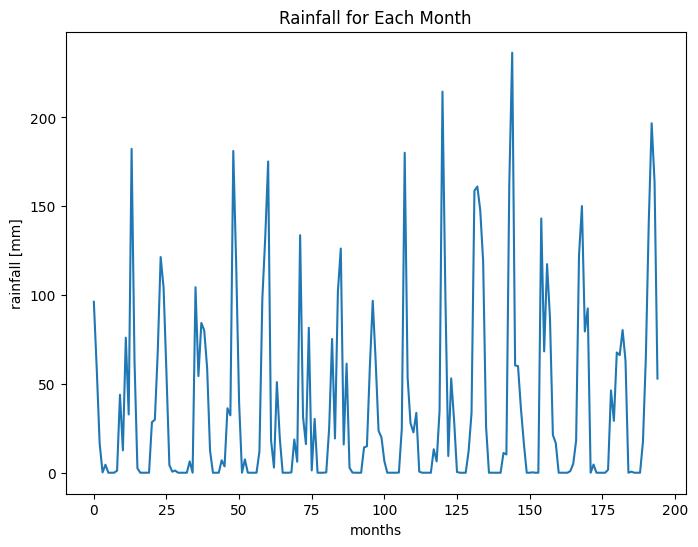

In [107]:
rainfall_2008_2024["Rainfall"].plot(figsize=(8, 6))
plt.title("Rainfall for Each Month")
plt.xlabel("months")
plt.ylabel("rainfall [mm]");

##### **Merge Datasets**

After creating the datasets of the temperature and rainfall, let us merge these attributes into a new single dataset:

In [81]:
avg_month_temp["Rainfall"] = rainfall_2008_2024["Rainfall"].values

weather_conditions_dataset = avg_month_temp

In [97]:
weather_conditions_dataset.to_csv("weather_conditions_2008_2024.csv", index_label="Date")

#### **Analysis**

In order to check for correlation and direction of effect between this exogenous variable and our original time series, let us performe linear regression:

In [84]:
X = weather_conditions_dataset.values
y = avg_month_level.loc["2008-01":"2024-03"].values

X = sm.add_constant(X)
model = sm.OLS(y, X)
model = model.fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.149
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                     11.11
Date:                Thu, 09 May 2024   Prob (F-statistic):           9.39e-07
Time:                        14:45:38   Log-Likelihood:                -350.68
No. Observations:                 195   AIC:                             709.4
Df Residuals:                     191   BIC:                             722.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -215.9252      0.970   -222.568      0.0

As we can see, we received the following coefficients:

- $β_{max-temp}=0.3983$ (positive effect)
- $β_{min-temp}=-0.4502$ (negative effect)
- $β_{rainfall}=0.0067$ (positive effect)

In addition the model’s $PV<10^(-6)$, and $R^2=0.149$.

This result indicates that there is some correlation between the two time series, with high statistical significance.


Now, let us present below a visual example for the relationship found, by displaying the rainfall and Kineret level time series, in a one-year time interval, alongside each other:

In [85]:
def plot_timeseries(records, col_name, title, ylabel):
  x_vals = [str(period) for period in records.index]
  y_vals = [val for val in records[col_name].values]

  plt.plot(x_vals, y_vals, color="r")
  plt.xticks([0, 15, 30, 45, 60, 75])

  plt.plot(x_vals, y_vals, color="r")
  plt.title(title)
  plt.xlabel("months")
  plt.ylabel(ylabel)
  plt.show()

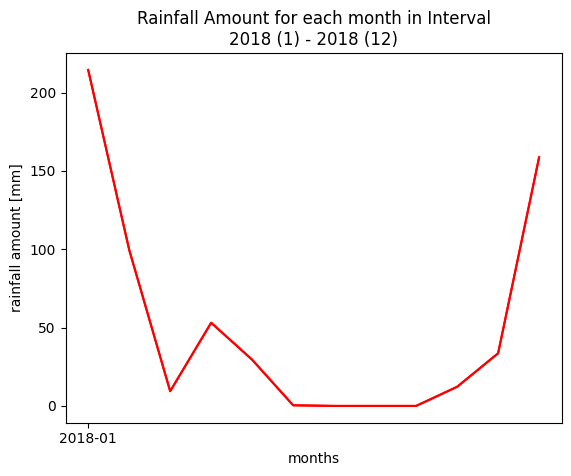

In [86]:
col_name = "Rainfall"
title = "Rainfall Amount for each month in Interval\n2018 (1) - 2018 (12)"
ylabel = "rainfall amount [mm]"

plot_timeseries(weather_conditions_dataset.loc["2018-01":"2018-12"], col_name, title, ylabel)

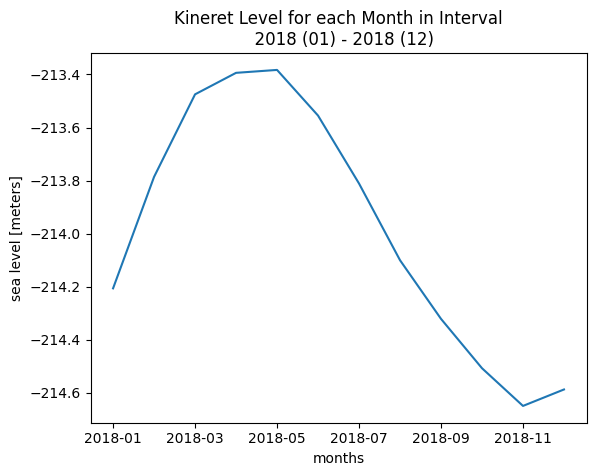

In [87]:
display_interval("2018-01", "2018-12")

As we can see, the Kineret level continues to rise, up until the rain stops (around June). In addition, in months when there is no rain, the Kineret level sharply declines. Lastly, although it starts raining again around September, the Kineret level starts to rise only a couple months later.

### **Man-made Explanatory Variable: Water Desalination**

The variable we chose is the total water desalination amount in Israel.

For this variable, the data was collected from the “Data Gov” website. For the most accurate results, we extracted all records available:  January 2016 until December 2024.

The data was collected in three datasets:

- desalination_2016_2019

- desalination_2020_2021

- desalination_2022

#### **Preprocessing**

Each of the datasets mentioned contains data regarding the monthly production of all desalination facilities in Israel.

In order to receive the total desalinated water production in Israel, for each month, we will sum all of its values across all desalination facilities.

Let us load and preprocess the data (please upload the [desalination_2016_2019.csv](https://drive.google.com/file/d/1i3FKmAuDJzlvIZ2SL46pmNktyAbHb5Iq/view?usp=sharing), [desalination_2020_2021.csv](https://drive.google.com/file/d/1X1BzxTcpDl_uCJCtV7etqAUFvTrs9exm/view?usp=sharing), [desalination_2022.csv](https://drive.google.com/file/d/19wug_j9wfyYJyJRc8IcmyPXJbuDsLb-6/view?usp=sharing) files to this notebook, from the project's drive):

In [88]:
desalination_2016_2019 = pd.read_csv("desalination_2016_2019.csv")
desalination_2020_2021 = pd.read_csv("desalination_2020_2021.csv")
desalination_2022 = pd.read_csv("desalination_2022.csv")

In [89]:
def clean_desal_dataset(desal_df, start_year, end_year):
  if "Date" in desal_df.columns:
    desal_df["Month"] = desal_df["Date"].apply(lambda date: date.split("/")[1])
    desal_df["Year"] = desal_df["Date"].apply(lambda date: date.split("/")[2])

    desal_df = desal_df.drop("Date", axis=1)

  month_desal = desal_df.groupby(["Year", "Month"]).sum()

  period_range = pd.period_range(start=f"{start_year}-01", end=f"{end_year}-12", freq="M")
  month_desal.set_index(period_range, inplace=True)
  month_desal = month_desal.apply(lambda x: round(x/1000000, 3))

  return month_desal

In [90]:
desal_2016_2019 = clean_desal_dataset(desalination_2016_2019, 2016, 2019)
desal_2020_2021 = clean_desal_dataset(desalination_2020_2021, 2020, 2021)
desal_2022 = clean_desal_dataset(desalination_2022, 2022, 2022)

desal_2016_2022 = pd.concat([desal_2016_2019, desal_2020_2021, desal_2022])

In [91]:
desal_2016_2022

,Desalinated Water Amount
2016-01,34.758
2016-02,36.079
2016-03,42.980
2016-04,43.436
2016-05,49.141
...,...
2022-08,52.908
2022-09,51.194
2022-10,52.635
2022-11,52.945


In [92]:
desal_2016_2022.to_csv("desalination_2016_2022.csv", index_label="Date")

Now, Let us display the water desalination time series:

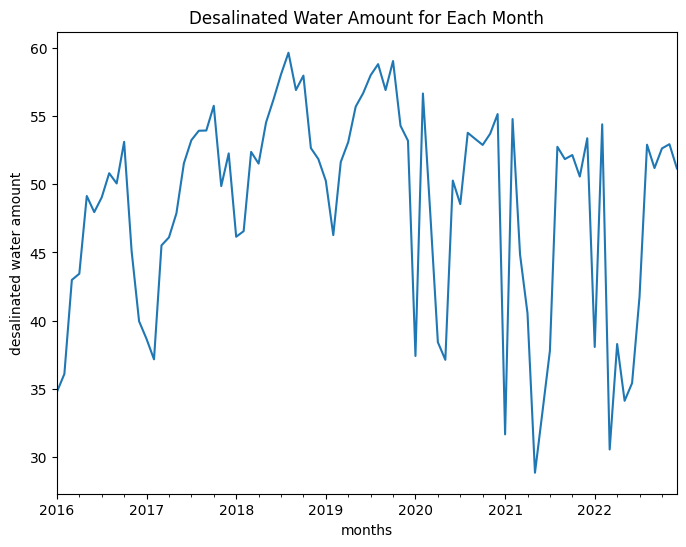

In [93]:
desal_2016_2022["Desalinated Water Amount"].plot(figsize=(8, 6))
plt.title("Desalinated Water Amount for Each Month")
plt.xlabel("months")
plt.ylabel("desalinated water amount");

#### **Analysis**

In order to check for correlation and direction of effect between this exogenous variable and our original time series, let us performe linear regression:

In [94]:
X = desal_2016_2022["Desalinated Water Amount"].values
y = dataset["Level"].loc["2016-01": "2022-12"].values

X = sm.add_constant(X)
model = sm.OLS(y, X)
model = model.fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     8.459
Date:                Thu, 09 May 2024   Prob (F-statistic):            0.00467
Time:                        14:45:39   Log-Likelihood:                -167.50
No. Observations:                  84   AIC:                             339.0
Df Residuals:                      82   BIC:                             343.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -208.0449      1.265   -164.404      0.0

As we can see, we received the coefficient: $β_{desalination}=-0.0749$.

Notice that the direction of effect is negative. This result surprised us at first, since we expected that when desalinating more water, less water would have to be extracted from the Kineret, resulting in higher sea levels. However, our data suggests otherwise. A reasonable explanation could be that water desalination capabilities could not fully fulfill (for now) the water demand in Israel. That is, the desalination production is probably planned according to the Kineret’s water extraction constraints.

In addition, the model’s $PV<0.005$, and $R^2=0.094$.

This result indicates that there is some correlation between the two time series, with high statistical significance. At first glance, it seems that the correlation is quite poor. However, let us remember that this variable contains a single attribute (compared to the three from the natural variable), and represents an action which is completely man-made. Hence, for it to receive above 60% of the natural variable’s $R^2$ score, is quite impressive in our eyes.


Now, let us present below a visual example for the relationship found, by displaying the time series in a specific time interval, side by side:

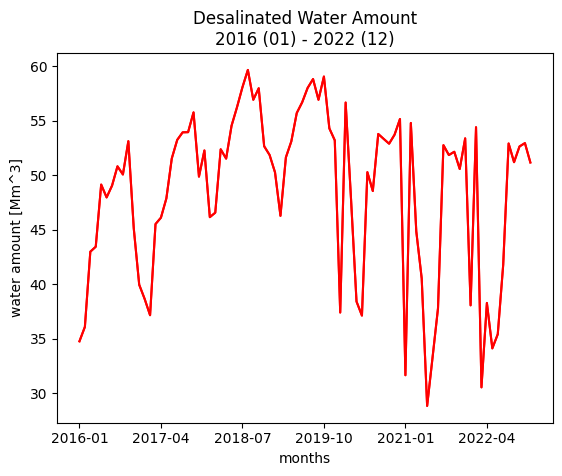

In [95]:
col_name = "Desalinated Water Amount"
title = "Desalinated Water Amount\n2016 (01) - 2022 (12)"
ylabel = "water amount [Mm^3]"

plot_timeseries(desal_2016_2022.loc["2016-01":"2022-12"], col_name, title, ylabel)

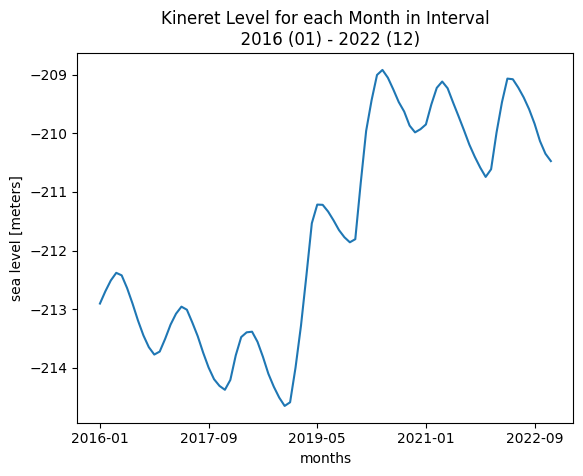

In [96]:
display_interval("2016-01", "2022-12")

As we can see from the graphs above, there was a steady decrease in the Kineret level from 2016 to 2019. In accordance to that phenomenon, we can see an upward trend in the production of desalinated water, during the same time period. In addition, after a major spike in the Kineret sea level, we can see a downward trend in the desalinated water production.